In [79]:
### Using Numpy because I started before I knew how to use pandas:
import numpy as np 
import pandas as pd
from datetime import datetime,timedelta
import itertools

from scipy import ndimage

from scipy.stats import norm, poisson, linregress, gaussian_kde, kde
from scipy.stats import f_oneway, pearsonr, ttest_ind
from scipy.stats import levene
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ks_2samp

from  matplotlib import pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm

from scipy.ndimage import gaussian_filter1d as GF
    
from scipy.io import wavfile as wf

import warnings
warnings.filterwarnings('ignore') ### there are deprecation and divide by zero warnings

SAVE = True # Save figs? 

0.95 0.1 0.6785714285714284 

0.8 0.30769230769230776
0.8105263157894738 0.3221757322175733
0.8210526315789474 0.33766233766233766
0.8315789473684211 0.35426008968609873
0.8421052631578948 0.37209302325581406
0.8526315789473684 0.3913043478260869
0.8631578947368421 0.41206030150753775
0.8736842105263158 0.43455497382198965
0.8842105263157896 0.4590163934426231
0.8947368421052632 0.48571428571428565
0.9052631578947369 0.5149700598802397
0.9157894736842105 0.5471698113207546
0.9263157894736842 0.5827814569536424
0.9368421052631579 0.6223776223776225
0.9473684210526316 0.666666666666667
0.9578947368421052 0.7165354330708661
0.968421052631579 0.7731092436974791
0.9789473684210527 0.8378378378378382
0.9894736842105263 0.9126213592233008
1.0 1.0


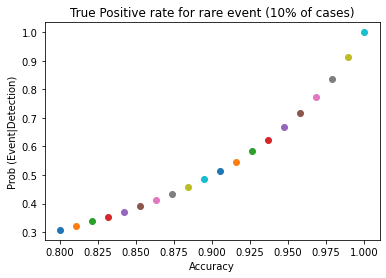

In [2]:
## Thinking about the probability of rare events, probably can skip
def bayes(b_a,a,b_na,na):
    return (b_a * a)/(b_a * a + b_na * na)

accuracy = .95

# For npb song
event_prob = .1
non_event_prob = 1-event_prob

args = [accuracy,event_prob,1-accuracy,non_event_prob]

print(accuracy,event_prob,bayes(*args),'\n')

fig,ax= plt.subplots()

for i in np.linspace(.8,1,20):
    accuracy = i
    args = [accuracy,event_prob,1-accuracy,non_event_prob]
    print(i,bayes(*args))
    ax.scatter(i,bayes(*args))
    
ax.set_title('True Positive rate for rare event (10% of cases)')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Prob (Event|Detection)')
fig.show()

In [5]:
## Load in OG data
fname = './AviaryDataFiles/2010raw_all_timeCorrected2.txt'
my_data = np.genfromtxt(fname, delimiter=',',dtype=str)

m8_data = my_data[my_data[:,6] == 'M8'] ## These ones have lesions, ignore them
m7_data = my_data[my_data[:,6] == 'M7']
m6_data = my_data[my_data[:,6] == 'M6']
m5_data = my_data[my_data[:,6] == 'M5'] ## These ones have lesions, ignore them

In [6]:
## deal with another data file: 
fname2 = './AviaryDataFiles/BS2017.txt'
test_data = np.genfromtxt(fname2,delimiter=',',dtype=str)

reorder = [4,5,6,7,8,1,3]
reorder_data = test_data[:,reorder]

dar_data = reorder_data[reorder_data[:,6] == 'DARWIN']
cop_data = reorder_data[reorder_data[:,6] == 'COOP']


In [7]:
##Even more data files!
data_2006 = np.genfromtxt('./AviaryDataFiles/2006.txt',delimiter=',',dtype=str)
data_2007 = np.genfromtxt('./AviaryDataFiles/2007_spring.txt',delimiter=',',dtype=str)
data_2008 = np.genfromtxt('./AviaryDataFiles/2008.txt',delimiter=',',dtype=str)

reorder = [3,4,5,6,7,1,2]
data_2006 = data_2006[:,reorder]
data_2007 = data_2007[:,reorder]
data_2008 = data_2008[:,reorder]

m1_06data = data_2006[data_2006[:,6] == 'M1']
m2_06data = data_2006[data_2006[:,6] == 'M2']
m3_06data = data_2006[data_2006[:,6] == 'M3']
m4_06data = data_2006[data_2006[:,6] == 'M4']

m1_07data = data_2007[data_2007[:,6] == 'M1']
m2_07data = data_2007[data_2007[:,6] == 'M2']
m3_07data = data_2007[data_2007[:,6] == 'M3']
m4_07data = data_2007[data_2007[:,6] == 'M4']

m1_08data = data_2008[data_2008[:,6] == 'M1']
m2_08data = data_2008[data_2008[:,6] == 'M2']
m3_08data = data_2008[data_2008[:,6] == 'M3']
m4_08data = data_2008[data_2008[:,6] == 'M4']


In [44]:
## Define some time handling functions
def time_to_sec(h_time):
    hms = h_time.split(':')
    secs = int(hms[0]) * 3600 + int(hms[1]) * 60 + int(hms[2])
    return secs

### Returns the day of year from the unix timestamp.
def day_of_year(datestamp_s):
    return datetime.fromtimestamp(datestamp_s).timetuple().tm_yday

def timestamp_to_ymd(timestamp,date_format = '%Y-%m-%d'):
    return datetime.utcfromtimestamp(timestamp).strftime(date_format)

def date_to_sec(date,date_format = 'ymd'):
    if date_format == 'ymd':
        ymd = date.split('-')
        timestamp = datetime.strptime(date,'%y-%m-%d').timestamp()
    elif date_format == 'mdy':
        mdy = date.split('-')
        ymd = [mdy[2],mdy[0],mdy[1]]
        timestamp = datetime.strptime(date,'%m-%d-%y').timestamp()
    elif date_format == 'dmy':
        dmy = date.split('-')
        ymd = [dmy[2],dmy[1],dmy[0]]
        timestamp = datetime.strptime(date,'%d-%m-%y').timestamp()
    elif date_format == 'Ymd':
        ymd = date.split('-')
        timestamp = datetime.strptime(date,'%Y-%m-%d').timestamp()
    return timestamp, ymd

def get_timestamp(aviary_data,t,date_format='ymd'):
    t_secs = time_to_sec(aviary_data[t,3])
    d_secs,_ = date_to_sec(aviary_data[t,5],date_format)
    return d_secs + t_secs

def get_difference(aviary_data,t0,t1,date_format='ymd'):
    difference = get_timestamp(aviary_data,t1,date_format) - get_timestamp(aviary_data,t0,date_format)
    return difference

## Sort of a hack to deal with older data format
def fake_timestamp(blocked_data,t,year):
    blocks = np.unique(blocked_data[:,5].astype(int))
    n_blocks = len(blocks)
    years = 12 * 31 * 24 * 3600 * year
    fake_day = np.argwhere(blocks == int(blocked_data[t,5]))[0][0]
    days = 24 * 3600 * fake_day
    return days + years

## These are just little wrappers that allow for handling arrays with all nans
def nansumwrapper(a, **kwargs):
    if np.isnan(a).all():
        return np.nan
    else:
        return np.nansum(a, **kwargs)
    
def nanmeanwrapper(a, **kwargs):
    if np.isnan(a).all():
        return np.nan
    else:
        return np.nanmean(a, **kwargs)

In [16]:
## Define this meta data class object. It also perfoms some data parsing to handle dates and such. 
class Meta_data:
    def __init__(self,raw_data,name='unknown',date_format='ymd',cutoff=None):
        self.name = name
        self.n_points = len(raw_data)
        self.date_format = date_format
        
        self.datetime = np.empty([self.n_points],dtype=object)
        self.timestamps = np.empty([self.n_points])        
  
            
        for n in range(self.n_points):
            self.timestamps[n] = get_timestamp(raw_data, n,self.date_format)
            self.datetime[n] = raw_data[n,5] + ' ' + raw_data[n,3]   
        if cutoff != None:
            self.cutoff_dt = datetime.strptime(cutoff,'%y-%m-%d')
            self.cutoff = np.argmax(self.timestamps >= self.cutoff_dt.timestamp())
        else:
            self.cutoff = self.n_points
            self.cutoff_dt = None  
        self.n_points = self.cutoff
        tmp_ids = np.unique(raw_data[:self.cutoff,:2])
        b_ids = []
        for t in tmp_ids:
            if 'M' in t or 'F' in t:
                if t.upper() == 'FEMALE' or t.upper() == 'MALE':
                    continue
                else:
                    b_ids.append(t)
        #print(b_ids,self.cutoff)
        self.bird_ids = np.array(b_ids)
        self.n_birds = len(self.bird_ids)
        self.n_males = len(self.bird_ids[np.char.find(self.bird_ids,'M') == 0])
        self.n_females = len(self.bird_ids[np.char.find(self.bird_ids,'F') == 0])
        self.m_ids = self.bird_ids[np.char.find(self.bird_ids,'M') == 0]
        self.f_ids = self.bird_ids[np.char.find(self.bird_ids,'F') == 0]
        self.indices = dict(zip(self.bird_ids,range(len(self.bird_ids))))
        self.dates = np.unique([raw_data[:self.cutoff,5]])

## Pretty self explanatory function that sorts data by date, needs to know the format.
def sort_data(aviary_data, aviary='Unknown',date_format='ymd',cutoff=None):
    time_stamps = np.zeros([len(aviary_data)])
    for n in range(len(aviary_data)):
        time_stamps[n] = get_timestamp(aviary_data,n,date_format)
    sorted_data = aviary_data[time_stamps.argsort()]
    return sorted_data, Meta_data(sorted_data, aviary,date_format,cutoff=cutoff)


## Define cutoffs (some aviaries had disruptions, we don't use data after that point)
cutoffs = {
    'M1-2006':'2006-05-12',
    'M2-2006':'2006-05-12',
    'M3-2006':'2006-05-12',
    'M4-2006':'2006-05-12',
    'M1-2007':'2007-04-25',
    'M4-2007':'2007-04-25',
}

In [17]:
## Build all the sorted and meta data
m8_sorted, m8_meta = sort_data(m8_data, aviary='PH8-2010',date_format = 'ymd')
m7_sorted, m7_meta = sort_data(m7_data, aviary='PH7-2010',date_format = 'ymd')
m6_sorted, m6_meta = sort_data(m6_data, aviary='PH6-2010',date_format = 'ymd')
m5_sorted, m5_meta = sort_data(m5_data, aviary='PH5-2010',date_format = 'ymd')

dar_sorted, dar_meta = sort_data(dar_data, aviary='ON2-2017',date_format = 'dmy')
cop_sorted, cop_meta = sort_data(cop_data, aviary='ON1-2017',date_format = 'dmy')

m16_sorted,m16_meta = sort_data(m1_06data,aviary='PH1-2006',date_format = 'mdy',cutoff = '06-05-12')
m26_sorted,m26_meta = sort_data(m2_06data,aviary='PH2-2006',date_format = 'mdy',cutoff = '06-05-12')
m36_sorted,m36_meta = sort_data(m3_06data,aviary='PH3-2006',date_format = 'mdy',cutoff = '06-05-12')
m46_sorted,m46_meta = sort_data(m4_06data,aviary='PH4-2006',date_format = 'mdy',cutoff = '06-05-12')

m17_sorted,m17_meta = sort_data(m1_07data,aviary='PH1-2007',date_format = 'mdy',cutoff = '07-04-25')
m27_sorted,m27_meta = sort_data(m2_07data,aviary='PH2-2007',date_format = 'mdy')
m37_sorted,m37_meta = sort_data(m3_07data,aviary='PH3-2007',date_format = 'mdy')
m47_sorted,m47_meta = sort_data(m4_07data,aviary='PH4-2007',date_format = 'mdy',cutoff = '07-04-25')

## These ones have lesioned birds, and are thus excluded, but maybe could be included with a cutoff?
m18_sorted,m18_meta = sort_data(m1_08data,aviary='PH1-2008',date_format = 'mdy')
m28_sorted,m28_meta = sort_data(m2_08data,aviary='PH2-2008',date_format = 'mdy')
m38_sorted,m38_meta = sort_data(m3_08data,aviary='PH3-2008',date_format = 'mdy')
m48_sorted,m48_meta = sort_data(m4_08data,aviary='PH4-2008',date_format = 'mdy')

In [27]:
## Function for Parsing egg data

# This spits out the egg_array, which is n_dates x n_females x 3: [Fertile, Not_fertile, unknown]
# It also returns datestamps, which is just a list of dates that they checked eggs on. Voila!

def parse_eggs(aviary_eggs,meta,date_format = None):
    ## Build date array and key
    if date_format == None:
        date_format = meta.date_format

    date_stamps = []
    dates = np.unique(aviary_eggs[:,1])
    for d in range(len(dates)):
        timestamp,_ = date_to_sec(dates[d],date_format)
        date_stamps.append(timestamp)

    # Sort, and identify timespan
    date_stamps = sorted(date_stamps)
    delta_s = date_stamps[-1] - date_stamps[0]
    delta_d = delta_s / 3600 / 24

    ## Fill in the missing dates
    date_stamps = np.arange(date_stamps[0],date_stamps[-1] + 3600,3600*24)
    dates = [timestamp_to_ymd(t) for t in date_stamps]

    #print(len(dates),len(date_stamps))
    
    #n_dates = 14
    f_ids = meta.f_ids
    n_females = meta.n_females
    egg_array= np.zeros([len(dates),n_females+1,3])

    for d in range(len(dates)):
        eggs_by_date = aviary_eggs[aviary_eggs[:,1] == dates[d]]

        ## First sum up totals
        egg_labels,egg_counts = np.unique(eggs_by_date[:,4],return_counts=True)
        F_count = np.sum(egg_counts[egg_labels == 'F'])
        N_count = np.sum(egg_counts[egg_labels=='NF'])
        Un_count = np.sum(egg_counts) - F_count - N_count

        # Sum up each individual bird
        for f in range(len(f_ids)):
            eggs_by_female = eggs_by_date[eggs_by_date[:,9] == f_ids[f]]
            egg_labels_f,egg_counts_f = np.unique(eggs_by_female[:,4],return_counts=True)

            F_count_f = np.sum(egg_counts_f[egg_labels_f == 'F'])
            N_count_f = np.sum(egg_counts_f[egg_labels_f =='NF'])
            Un_count_f = np.sum(egg_counts_f) - F_count_f - N_count_f

            #print(F_count_f,N_count_f, Un_count_f)
            egg_array[d,f] = [F_count_f,N_count_f,Un_count_f]
        # Subtract total from individual to get unknown birds. In many years, most birds are unknown!
        totes_fem = np.sum(egg_array[d],0)
        egg_array[d,-1] = np.array([F_count,N_count,Un_count]) - totes_fem

    return egg_array,date_stamps
    

In [2]:
## Fix 2006-2008 data to be consistent, might need to do this with other files too...

if False:
    outfile = open('./AviaryDataFiles/2006_eggs_corrected.txt','w')
    with open('./AviaryDataFiles/2006_eggs.txt') as f:
        for line in f:
            split_line = line.split(',')
            for c in range(len(split_line)):
                split_line[c] = split_line[c].replace('/','-')
            mdy = split_line[1].split('-')
            for i in range(3):
                if len(mdy[i]) == 1:
                    mdy[i] = '0' + mdy[i]
            ymd = '-'.join([mdy[2],mdy[0],mdy[1]])
            split_line[1] = ymd
            outfile.write(','.join(split_line))
    outfile.close()

if False:
    outfile = open('./AviaryDataFiles/2008_eggs_corrected.txt','w')
    with open('./AviaryDataFiles/2008_eggs.txt') as f:
        for line in f:
            split_line = line.split(',')
            for c in range(len(split_line)):
                split_line[c] = split_line[c].replace('/','-')
            mdy = split_line[1].split('-')
            for i in range(3):
                if len(mdy[i]) == 1:
                    mdy[i] = '0' + mdy[i]
            ymd = '-'.join([mdy[2],mdy[0],mdy[1]])
            split_line[1] = ymd
            outfile.write(','.join(split_line))
    outfile.close()

In [86]:
## Parse Egg files!

## Needed to correct the format in 2006...see cell above
eggs_2006 = np.genfromtxt('./AviaryDataFiles/2006_eggs_corrected.txt',delimiter=',',dtype=str)
eggs_2007 = np.genfromtxt('./AviaryDataFiles/2007_eggs_corrected.txt',delimiter=',',dtype=str)
eggs_2008 = np.genfromtxt('./AviaryDataFiles/2008_eggs_corrected.txt',delimiter=',',dtype=str)

eggs_2009 = np.genfromtxt('./AviaryDataFiles/Eggs_2009.txt',delimiter=',',dtype=str)
eggs_2010 = np.genfromtxt('./AviaryDataFiles/Eggs_2010.txt',delimiter=',',dtype=str)

m16_egg_data = eggs_2006[eggs_2006[:,2] == 'M1']
m26_egg_data = eggs_2006[eggs_2006[:,2] == 'M2']
m36_egg_data = eggs_2006[eggs_2006[:,2] == 'M3']
m46_egg_data = eggs_2006[eggs_2006[:,2] == 'M4']

m17_egg_data = eggs_2007[eggs_2007[:,2] == 'M1']
m27_egg_data = eggs_2007[eggs_2007[:,2] == 'M2']
m37_egg_data = eggs_2007[eggs_2007[:,2] == 'M3']
m47_egg_data = eggs_2007[eggs_2007[:,2] == 'M4']

m18_egg_data = eggs_2008[eggs_2008[:,2] == 'M1']
m28_egg_data = eggs_2008[eggs_2008[:,2] == 'M2']
m38_egg_data = eggs_2008[eggs_2008[:,2] == 'M3']
m48_egg_data = eggs_2008[eggs_2008[:,2] == 'M4']

m29_egg_data = eggs_2009[eggs_2009[:,2] == 'M2']
m69_egg_data = eggs_2009[eggs_2009[:,2] == 'M6']
m79_egg_data = eggs_2009[eggs_2009[:,2] == 'M7']
m89_egg_data = eggs_2009[eggs_2009[:,2] == 'M8']

m50_egg_data = eggs_2010[eggs_2010[:,2] == 'M5']
m60_egg_data = eggs_2010[eggs_2010[:,2] == 'M6']
m70_egg_data = eggs_2010[eggs_2010[:,2] == 'M7']
m80_egg_data = eggs_2010[eggs_2010[:,2] == 'M8']



m80_egg_array,m80_datestamps = parse_eggs(m80_egg_data,m8_meta,date_format='Ymd')
m70_egg_array,m70_datestamps = parse_eggs(m70_egg_data,m7_meta,date_format='Ymd')
m60_egg_array,m60_datestamps = parse_eggs(m60_egg_data,m6_meta,date_format='Ymd')
m50_egg_array,m50_datestamps = parse_eggs(m50_egg_data,m5_meta,date_format='Ymd')
"""
# Currently don't have meta for those years, skipped because of lesions i think?
m29_egg_array,m29_datestamps = parse_eggs(m29_eggs,m#_meta)
m69_egg_array,m69_datestamps = parse_eggs(m69_eggs,m#_meta)
m79_egg_array,m79_datestamps = parse_eggs(m79_eggs,m#_meta)
m89_egg_array,m89_datestamps = parse_eggs(m89_eggs,m#_meta)
"""
m16_egg_array,m16_datestamps = parse_eggs(m16_egg_data,m16_meta,date_format='Ymd')
m26_egg_array,m26_datestamps = parse_eggs(m26_egg_data,m26_meta,date_format='Ymd')
m36_egg_array,m36_datestamps = parse_eggs(m36_egg_data,m36_meta,date_format='Ymd')
m46_egg_array,m46_datestamps = parse_eggs(m46_egg_data,m46_meta,date_format='Ymd')

m17_egg_array,m17_datestamps = parse_eggs(m17_egg_data,m17_meta,date_format='Ymd')
m27_egg_array,m27_datestamps = parse_eggs(m27_egg_data,m27_meta,date_format='Ymd')
m37_egg_array,m37_datestamps = parse_eggs(m37_egg_data,m37_meta,date_format='Ymd')
m47_egg_array,m47_datestamps = parse_eggs(m47_egg_data,m47_meta,date_format='Ymd')

m18_egg_array,m18_datestamps = parse_eggs(m18_egg_data,m18_meta,date_format='Ymd')
m28_egg_array,m28_datestamps = parse_eggs(m28_egg_data,m28_meta,date_format='Ymd')
m38_egg_array,m38_datestamps = parse_eggs(m38_egg_data,m38_meta,date_format='Ymd')
m48_egg_array,m48_datestamps = parse_eggs(m48_egg_data,m48_meta,date_format='Ymd')

egg16_cutoff = np.argmin(m16_datestamps <= m16_meta.timestamps[m16_meta.cutoff])
egg26_cutoff = np.argmin(m26_datestamps <= m26_meta.timestamps[m26_meta.cutoff])
egg36_cutoff = np.argmin(m36_datestamps <= m36_meta.timestamps[m36_meta.cutoff])
egg46_cutoff = np.argmin(m46_datestamps <= m46_meta.timestamps[m46_meta.cutoff])

egg_cutoffs = [egg16_cutoff,egg26_cutoff,egg36_cutoff,egg46_cutoff]
all_eggs = [m16_egg_array,m26_egg_array,m36_egg_array,m46_egg_array,
           m17_egg_array,m27_egg_array,m37_egg_array,m47_egg_array,
           m18_egg_array,m28_egg_array,m38_egg_array,m48_egg_array,
           m50_egg_array,m60_egg_array,m70_egg_array,m80_egg_array]

#          m29_egg_array,m69_egg_array,m79_egg_array,m89_egg_array,
all_datestamps = [m16_datestamps,m26_datestamps,m36_datestamps,m46_datestamps,
                 m17_datestamps,m27_datestamps,m37_datestamps,m47_datestamps,
                 m18_datestamps,m28_datestamps,m38_datestamps,m48_datestamps,
                 m50_datestamps,m60_datestamps,m70_datestamps,m80_datestamps]
#                m29_datestampes,m69_datestamps,m79_datestamps,m89_datestamps,

print('All done!')

All done!


In [112]:
## Count eggs before cutoffs

print(egg_cutoffs)

for i in range(4):
    egg_array = all_eggs[i]
    egg_cutoff = egg_cutoffs[i]
    print('n_eggs:',np.sum(egg_array[:egg_cutoff]))
    print('eggs_by_day:',np.sum(egg_array[:egg_cutoff],axis=(1,2)))
    print('dates:',[day_of_year(d) for d in all_datestamps[i][:egg_cutoff]])
    print('n_females,males:',metas[i].n_females, metas[i].n_males)


[8, 6, 7, 6]
n_eggs: 15.0
eggs_by_day: [1. 0. 2. 3. 3. 1. 3. 2.]
dates: [125, 126, 127, 128, 129, 130, 131, 132]
n_females,males: 12 5
n_eggs: 8.0
eggs_by_day: [1. 1. 1. 2. 2. 1.]
dates: [127, 128, 129, 130, 131, 132]
n_females,males: 13 14
n_eggs: 21.0
eggs_by_day: [1. 1. 2. 5. 4. 5. 3.]
dates: [126, 127, 128, 129, 130, 131, 132]
n_females,males: 11 6
n_eggs: 8.0
eggs_by_day: [1. 2. 2. 1. 0. 2.]
dates: [127, 128, 129, 130, 131, 132]
n_females,males: 13 16
['03-15-06' '03-17-06' '03-20-06' '03-22-06' '03-27-06' '03-31-06'
 '04-07-06' '04-12-06' '04-13-06' '04-14-06' '04-17-06' '04-20-06'
 '04-21-06' '04-28-06' '04-29-06' '04-30-06' '05-01-06' '05-03-06'
 '05-04-06' '05-05-06' '05-06-06' '05-07-06' '05-08-06' '05-09-06'
 '05-10-06' '05-11-06']


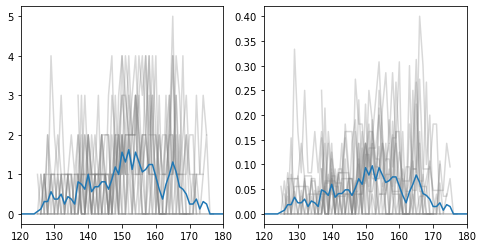

In [64]:
## Visualize Eggs

fig,(ax,ax1) = plt.subplots(1,2)

decade_of_eggs = np.zeros(366)

for a in range(len(all_eggs)):
    
    egg_array = all_eggs[a]
    datestamps = all_datestamps[a]
    n_females = np.shape(egg_array)[1]
    days_of_our_lives = [day_of_year(d) for d in datestamps]
    day_counts = np.sum(egg_array[:,:,[0]],axis=(1,2))
    for i in range(len(datestamps)):
        d = day_of_year(datestamps[i])
        decade_of_eggs[d] += day_counts[i]
    ax.plot(days_of_our_lives,day_counts,alpha=.3,color='gray')
    ax1.plot(days_of_our_lives,np.array(day_counts) / n_females,alpha=.3,color='gray')

mean_females = np.mean([a.shape[1] for a in all_eggs])
ax.plot(range(366),decade_of_eggs/len(all_eggs))
ax1.plot(range(366),decade_of_eggs/len(all_eggs)/mean_females)
ax.set_xlim(120,180)
ax1.set_xlim(120,180)

fig.set_size_inches(8,4)
fig.show()

In [65]:
## Builds history plot of every interaction
def build_history(aviary_data, meta_data):
    interactions = np.zeros([meta_data.n_points, meta_data.n_birds,meta_data.n_birds])
    copulations = np.zeros([meta_data.n_points, meta_data.n_birds, meta_data.n_birds])
    for p in range(meta_data.cutoff):
        i_str = aviary_data[p,0]
        j_str = aviary_data[p,1]
        i = meta_data.indices[i_str]
        if j_str in meta_data.indices.keys():
            j = meta_data.indices[j_str]
        else:
            j = i
            #print(aviary_data[p])
        interactions[p,i,j] = 1
        if aviary_data[p,2] == 'copulation':
            copulations[p,i,j] = 5
    return interactions, copulations

In [66]:
## This is like build history, but it's cumulative, each point adds to itself
## Additionally, it decays over time
## I don't use this, but it's pretty neat, play around with it if you want

def overlap_history(aviary_data, meta_data):
    interactions = np.empty([meta_data.cutoff, meta_data.n_birds, meta_data.n_birds])
    copulations = np.empty_like(interactions)
    lag = .99
    for p in range(meta_data.cutoff):
        i_str = aviary_data[p,0]
        j_str = aviary_data[p,1]
        i = meta_data.indices[i_str]
        if j_str in meta_data.indices.keys():
            j = meta_data.indices[j_str]
        else:
            j = i
        interactions[p,i,j] = 1
        interactions[p,:,:] = interactions[p,:,:] + interactions[p-1,:,:] * lag
        if aviary_data[p,2] == 'copulation':
            #print('Copulation!')
            copulations[p,i,j] = 5
        copulations[p,:,:] = copulations[p,:,:] + copulations[p-1,:,:] ** .99
    return interactions, copulations

In [67]:
## Build all the history objects, as well as the lists of histories, sorteds, and meta data

m8_history, m8_copulations = build_history(m8_sorted, m8_meta)
m7_history, m7_copulations = build_history(m7_sorted, m7_meta)
m6_history, m6_copulations = build_history(m6_sorted, m6_meta)
m5_history, m5_copulations = build_history(m5_sorted, m5_meta)

cop_history, cop_copulations = build_history(cop_sorted,cop_meta)
dar_history, dar_copulations = build_history(dar_sorted,dar_meta)

m16_history,m16_copulations = build_history(m16_sorted,m16_meta)
m26_history,m26_copulations = build_history(m26_sorted,m26_meta)
m36_history,m36_copulations = build_history(m36_sorted,m36_meta)
m46_history,m46_copulations = build_history(m46_sorted,m46_meta)

m17_history,m17_copulations = build_history(m17_sorted,m17_meta)
m27_history,m27_copulations = build_history(m27_sorted,m27_meta)
m37_history,m37_copulations = build_history(m37_sorted,m37_meta)
m47_history,m47_copulations = build_history(m47_sorted,m47_meta)

m18_history,m18_copulations = build_history(m18_sorted,m18_meta)
m28_history,m28_copulations = build_history(m28_sorted,m28_meta)
m38_history,m38_copulations = build_history(m38_sorted,m38_meta)
m48_history,m48_copulations = build_history(m48_sorted,m48_meta)


## Some aviaries have lesions (m5,m8) and others have repeat birds (2008) so we don't include those
historys = [m16_history,m26_history,m36_history,m46_history,
            m17_history,m27_history,m37_history,m47_history,m6_history,m7_history,cop_history,dar_history] 
sorteds = [m16_sorted,m26_sorted,m36_sorted,m46_sorted,
           m17_sorted,m27_sorted,m37_sorted,m47_sorted,m6_sorted, m7_sorted, cop_sorted, dar_sorted]
metas = [m16_meta,m26_meta,m36_meta,m46_meta,
         m17_meta,m27_meta,m37_meta,m47_meta,m6_meta,m7_meta,cop_meta,dar_meta]
copulations = [m16_copulations,m26_copulations,m36_copulations,m46_copulations,
         m17_copulations,m27_copulations,m37_copulations,m47_copulations,
               m6_copulations,m7_copulations,cop_copulations,dar_copulations]

In [68]:
for m in metas:
    print(m.name,m.n_females)
    

PH1-2006 12
PH2-2006 13
PH3-2006 11
PH4-2006 13
PH1-2007 27
PH2-2007 15
PH3-2007 20
PH4-2007 24
PH6-2010 11
PH7-2010 10
ON1-2017 21
ON2-2017 19


In [69]:
## Function that takes data, and shuffles by individual
def shuffle_indy_data(sorted_data, meta):
    singers = np.unique(sorted_data[:,0])

    shuffled_data = np.empty_like(m16_sorted)
    for s in singers:
        singer_data = m16_sorted[m16_sorted[:,0] == s]
        shuffled_singer = np.array(singer_data)
        shuffled_singer[:,3:] = np.random.permutation(singer_data[:,3:]) ## Shuffle the time stamps, leave annotation the same
        shuffled_data[sorted_data[:,0] == s] = shuffled_singer

    indy_shuffled,indy_shuffled_meta = sort_data(shuffled_data,aviary=meta.name,date_format = meta.date_format)
    return indy_shuffled,indy_shuffled_meta

m16_indy_shuffled,m16_indy_shuffled_meta = shuffle_indy_data(m16_sorted,m16_meta)
print(m16_sorted[0])
print(m16_indy_shuffled[0])

['MBOG' '' '' '00:00:00' '23' '03-15-06' 'M1']
['MDMD' 'MGNB' '' '00:00:00' '20' '03-15-06' 'M1']


(6294, 7)
(7457, 7)
(6455, 7)
(8962, 7)
(11525, 7)
(10955, 7)
(10344, 7)
(10327, 7)
(6982, 7)
(7201, 7)
(4570, 7)
(3523, 7)


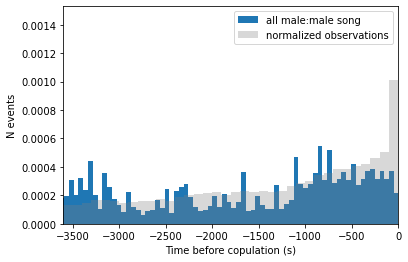

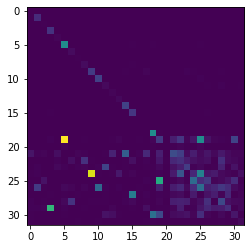

In [70]:
## Check for patterns prior to copulations

def rewind(meta,i,seconds,max_time = None):
    focal_time = meta.timestamps[i]
    past_times = np.argwhere((meta.timestamps >= (focal_time - seconds)) & (meta.timestamps < focal_time))

    if len(past_times) == 0:
        return i
    else:
        return past_times[0,0]

songs = []
boy_songs = []
boys2men = []
event_stamps = []
male_stamps = []
background_observations = []
for a in range(len(copulations)):
    #a = 0
    cops = copulations[a]
    daviary = sorteds[a]
    meta = metas[a]
    history = historys[a]
    print(daviary.shape)

    ts,ms,fs = np.where(cops ==5)

    for c in range(len(ts)):
        
        i = ts[c]
        i0 = rewind(meta,i,3900)

        #print(ts[c],ms[c],fs[c])
        window = history[i0:i,ms[c],fs[c]]
        #male_window = np.sum(history[i0:i,ms[c],meta.n_females:],1)
        male_window = np.sum(history[i0:i,meta.n_females:,meta.n_females:],1)
        background_window = np.sum(history[i0:i],axis=(1,2))
        events = np.argwhere(window == 1) + i0
        m_events = np.argwhere(male_window == 1) + i0
        b_events = np.argwhere(background_window == 1) + i0
        #print('timestamps,0:',meta.timestamps[events],meta.timestamps[i])
        event_stamps.extend(np.array(meta.timestamps[events] - meta.timestamps[i]).flatten())
        male_stamps.extend(np.array(meta.timestamps[m_events] - meta.timestamps[i]).flatten())
        b_stamps = np.array(meta.timestamps[b_events] - meta.timestamps[i]).flatten()
        b_stamps = np.unique(np.around(b_stamps,-2))
        background_observations.extend(b_stamps)
        #event_stamps.extend(np.array(meta.timestamps[events] - meta.timestamps[i]))
        #print(i0,events)
        #print(event_stamps)
        #print(meta.timestamps[events])
        #print(meta.timestamps[i])
        #print(meta.timestamps[events] - meta.timestamps[i])

        #songs.append(np.array(history[i0:i+1,ms[c],fs[c]]))
        #timestamps.append(meta.timestamps[i0:i+1] - meta.timestamps[i])
        #boy_songs.append(np.array(np.sum(history[i-100:i+1,ms[c],:],1)))
        #boys2men.append(np.array(np.sum(history[i-100:i+1],axis=(1,2))))   
        
"""
print(np.array(songs).shape)
summed_songs = np.sum(np.array(songs),0)
summed_boys = np.sum(np.array(boy_songs),0)
summed_men = np.sum(np.array(boys2men),0)

print(summed_boys)
summed_boys[100] = 0
summed_songs[100] = 0
summed_men[100] = 0   
"""     
fig,ax = plt.subplots()
#print(event_stamps)
hist_stamps = ax.hist(male_stamps,bins=78,label='all male:male song',density=True)
hist_br = ax.hist(background_observations,bins=39,alpha=.3,label='normalized observations',color='gray',density=True)

hist_stamps = np.histogram(male_stamps,bins=156)
hist_br = np.histogram(background_observations,bins=39)
hist_fem = np.histogram(event_stamps,bins=120)


#ax.hist(event_stamps,bins=120,label='songs between copulating pair',density=True)
ax.set_xlim([-3600,0])
#ax.set_ylim([0,300])

ax.set_xlabel('Time before copulation (s)')
ax.set_ylabel('N events')
"""ax.plot(summed_songs)
ax.plot(summed_boys)
ax.plot(summed_men)"""
ax.legend()

fig.show()

fig,ax = plt.subplots()
ax.imshow(np.sum(history,0))
fig.show()

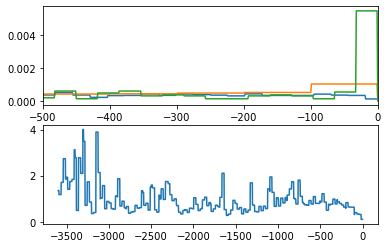

In [516]:
## Get a sense of the distribution of events
from scipy import stats
fig, (ax,ax1) = plt.subplots(2)
stamp_dist = stats.rv_histogram(hist_stamps)
br_dist = stats.rv_histogram(hist_br)
fem_dist = stats.rv_histogram(hist_fem)

X = np.linspace(-3600,0,3600)
ax.plot(X,stamp_dist.pdf(X))
ax.plot(X,br_dist.pdf(X))
ax.plot(X,fem_dist.pdf(X))
ax1.plot(X,stamp_dist.pdf(X)/br_dist.pdf(X))

ax.set_xlim(-500,0)
fig.show()

In [71]:
## Count some stuff:

males = 0
females = 0
observations = 0
days = 0
for m in metas:
    males += m.n_males
    females += m.n_females
    observations += len(m.timestamps)
    days += len(np.unique(m.dates))

print('Males,Females,n_days,n oberservations')
print(males,females,observations,days)
print('total copulations:',np.sum(np.sum(c) for c in copulations))

Males,Females,n_days,n oberservations
119 196 94595 407
total copulations: 605.0


5 12
14 13
6 11
16 13
10 27
8 15
8 20
11 24
8 11
9 10
11 21
13 19


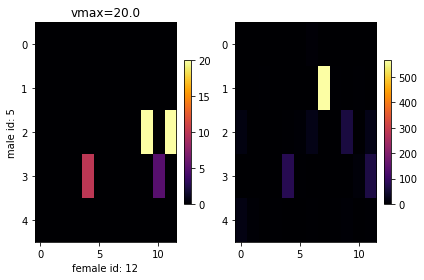

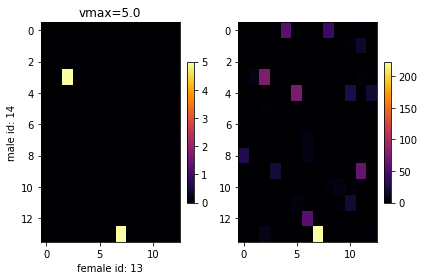

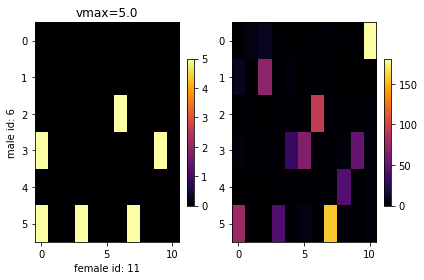

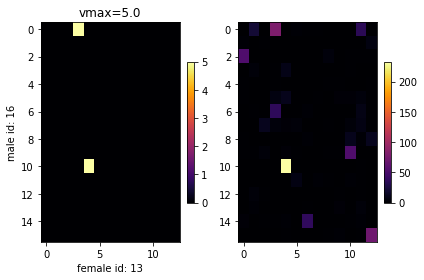

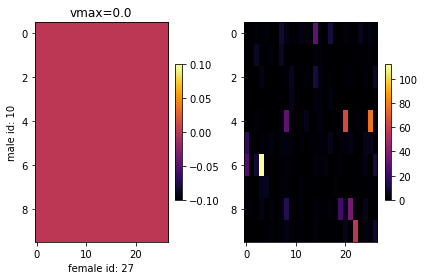

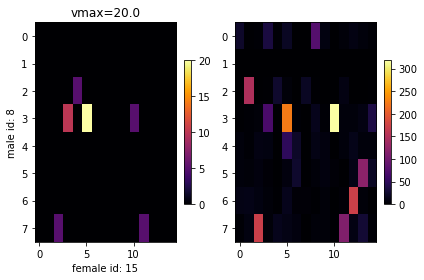

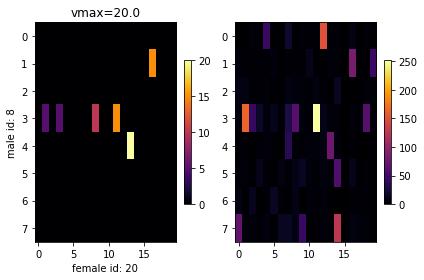

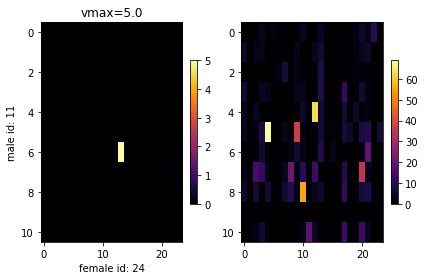

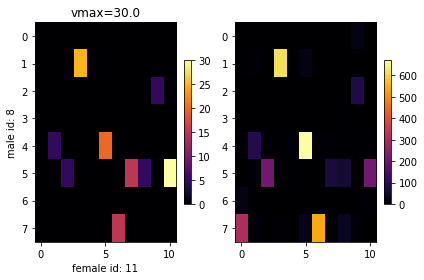

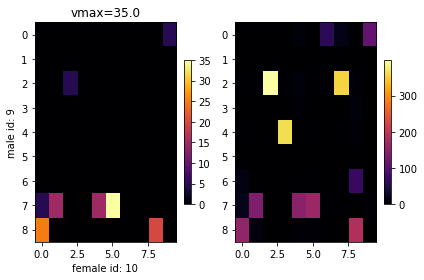

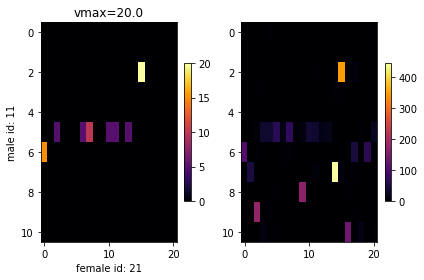

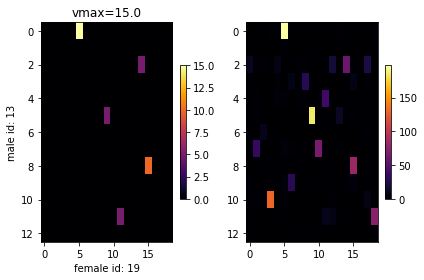

In [72]:
## Check out copulations and songs. 

for c in range(len(copulations)):
    copulation = copulations[c]
    history = historys[c]
    #n_females = metas[c].n_females
    fig,(ax,ax1) = plt.subplots(1,2)
    #print(copulations[0].shape)
    n_females = metas[c].n_females
    n_males = metas[c].n_males
    print(metas[c].n_males,metas[c].n_females)
    cops = ax.imshow(np.sum(copulation,axis=0)[n_females:,:n_females],cmap='inferno',aspect='auto')
    fig.colorbar(cops,fraction=0.046,ax=ax)
    songs = ax1.imshow(np.sum(history,axis=0)[n_females:,:n_females],cmap='inferno',aspect='auto')
    fig.colorbar(songs,fraction=0.046,ax=ax1)
    ax.set_xlabel('female id: ' + str(metas[c].n_females))
    ax.set_ylabel('male id: ' + str(metas[c].n_males))
    ax.set_title('vmax=' + str(np.max(np.sum(copulation,axis=0))))
    fig.tight_layout()
    fig.show()

In [73]:
## Define f_attention function, which identifies how females allocate rattles
## Returns f_calls, f_leaves, m_songs,[mean_ratios,rattle_dates,song_dates]
## This function is doing a lot of work now, it's a bit unweildy...
def f_attention(history_data, sorted_data, meta_data):
    rattle_dates_raw = np.zeros([n_days,meta_data.n_females,6])
    rattle_dates = np.zeros([n_days,meta_data.n_females,4])
    song_dates = np.zeros_like(rattle_dates)
    ## REMEBER To change this: 
    #song_dates =np.empty_like(rattle_dates)
    #song_dates.fill(np.nan)
    f_pairmates = np.empty(meta_data.n_females)
    f_vicemates = np.empty(meta_data.n_females)
    
    ## Build the pairbond and vice pairbond lists that I'll need to use

    for f in range(meta_data.n_females):
        
        ## This needs to be cutoff:
        song_sums = history_data[:meta_data.cutoff].sum(0)[meta_data.n_females:,f]
        #print(song_sums,f)
        #print(f_pairmates,np.argmax(song_sums))
        f_pairmates[f] = int(np.argmax(song_sums))
        #print(f_pairmates[f])
        song_sums[int(f_pairmates[f])] = 0 
        #print(song_sums)
        
        f_vicemates[f] = np.argmax(song_sums)
        #print(f_pairmates,f_vicemates)
        
        
    meta_data.f_pairmates = f_pairmates
    meta_data.f_vicemates = f_vicemates
    
    f_calls = np.zeros([meta_data.n_females,meta_data.n_males])

    f_leaves = np.zeros([meta_data.n_females,meta_data.n_males])
    m_songs = np.zeros([meta_data.n_males,meta_data.n_females])
    ## Every time there's a rattle, add it to rattle counts, and add it to the by_day array

    for n in range(meta_data.cutoff):
        
        i = sorted_data[n,0]
        j = sorted_data[n,1]
        info = sorted_data[n,2]
        
        ## Get the date for this row (just need the day in this case)
        date_raw = sorted_data[n,5]
        _,ymd = date_to_sec(date_raw,meta_data.date_format)
        md = str(ymd[1] + '-' + ymd[2])
        day_index = day_to_index[md]
        
        ## Deal with all Male > interactions
        if i in meta_data.m_ids or i == 'male':
            ## For now, ignore all male> interactions
            if j in meta_data.m_ids or j == 'male':
                pass
            ## Otherwise, if it's a female, put it in male-female
            elif j in meta_data.f_ids:
                female = np.where(meta_data.f_ids == j)[0][0]
                male = np.where(meta_data.m_ids == i)[0][0]
                #print(f_pairmates[female],male)
                if f_pairmates[female] == male:
                    shift = 0
                    #print('pairbond!')
                elif f_vicemates[female] == male:
                    shift = 2
                else:
                    shift = 4
                m_songs[male,female] = m_songs[male,female] + 1
                ## ****Add the male song****
                rattle_dates_raw[day_index,female,0+shift] += 1
                
                ## Add valence, does it elicit a positive--or negative--response?
                if info.lower() == 'rattle': 
                    f_calls[female,male] = f_calls[female,male] + 1
                    ## ****Add the rattle****
                    #print('rattle!')
                    rattle_dates_raw[day_index,female,1+shift] += 1
                elif info.lower() == 'leave' or info.lower() == 'depart':
                    f_leaves[female,male] = f_leaves[female,male] + 1
            ## Otherwise it's male-unknown
            else:
                pass
        ## Deal with the few female > interactions
        elif i in meta_data.f_ids:
            if j in meta_data.m_ids:
                male = np.where(meta_data.m_ids == j)
                female = np.where(meta_data.f_ids==i)
                #if info == 'leave' or info == 'lunge':
                if info.lower() == 'leave' or info.lower() == 'depart':
                    f_leaves[female,male] = f_leaves[female,male] + 1
                elif info.lower() == 'rattle':
                    f_calls[female,male] = f_calls[female,male] + 1
            elif j in meta_data.f_ids or j == 'female':
                pass
            ## I don't actually use this logic anymore since I'm averaging, but it could be useful.
            if sorted_data[n-1,1] == i: # If the female was just sung to
                previous_singer = sorted_data[n-1,0]
                if previous_singer in meta_data.m_ids: ## This means she was just sung to by a male
                    male = np.where(meta_data.m_ids == previous_singer)
                    
                    #m_songs[male,female] = m_songs[male,female] + 1

                    if j.lower() == 'rattle':
                        pass
                        #f_calls[female,male] = f_calls[female,male] + 1
                    elif j.lower() == 'leave' or j.lower() == 'depart':
                        pass
                        #f_leaves[female,male] = f_leaves[female,male] + 1     
            else:
                pass
        ## Deal with any other/unknown interactions
        else:
            pass
    #print(np.max(rattle_dates_raw,1))
    ## Allow for a sliding window, if win=0 this just takes the day
    win = 0
    padded_dates = np.zeros([len(rattle_dates_raw) + win*2,meta_data.n_females,6])
    if win == 0:
        padded_dates = np.array(rattle_dates_raw)
    else:
        padded_dates[win:-win] = rattle_dates_raw
    
    for d in range(len(rattle_dates_raw)):
        p = d + win
        for b in range(meta_data.n_females):
            q = p-win
            r = p+win+1
            
            ## vpb is the vice pairbond, o is all other birds (i.e. 3rd-worst)
            
            vpb_rattles = np.nansum(padded_dates[q:r,b,3])
            o_rattles = np.nansum(padded_dates[q:r,b,5])
            
            vpb_songs = np.nansum(padded_dates[q:r,b,2])
            o_songs = np.nansum(padded_dates[q:r,b,4])
            pb_songs = np.nansum(padded_dates[q:r,b,0])
            all_other_songs = o_songs + vpb_songs
            
            pb_ratio= np.sum(padded_dates[q:r,b,1]) / (np.sum(padded_dates[q:r,b,0]))# + .0001)
            vpb_ratio= np.sum(padded_dates[q:r,b,3]) / (np.sum(padded_dates[q:r,b,2]))# + .0001)
            o_ratio= np.sum(padded_dates[q:r,b,5]) / (np.sum(padded_dates[q:r,b,4]))# + .0001)
            
            if ~np.isnan(pb_ratio):
                pb_ratio = np.clip(pb_ratio,0,1)
            if ~np.isnan(vpb_ratio):
                vpb_ratio = np.clip(vpb_ratio,0,1)
            if ~np.isnan(o_ratio):
                o_ratio = np.clip(o_ratio,0,1)
            all_other_ratio = (o_rattles + vpb_rattles) / (o_songs + vpb_songs)
            if ~np.isnan(all_other_ratio):
                all_other_ratio = np.clip(all_other_ratio,0,1)
            """
            pb_ratio =  rattle_dates_raw[d,b,1] / (rattle_dates_raw[d,b,0] + .0001)
            vpb_ratio = rattle_dates_raw[d,b,3] / (rattle_dates_raw[d,b,2] + .0001) 
            ## This could be all other, or non-vice other. I've chosen all other here. 
            o_ratio = (rattle_dates_raw[d,b,3] + rattle_dates_raw[d,b,5]) / (.0001 + rattle_dates_raw[d,b,2] + rattle_dates_raw[d,b,4])
            """
            pb_ratio = np.round(pb_ratio,3)
            vpb_ratio = np.round(vpb_ratio,3)
            o_ratio = np.round(o_ratio,3)
            ## Deal with 0:nan cases. If no song, ratio is nan, not infinity, or 0. 
            if rattle_dates_raw[d,b,0] == 0:
                pb_ratio = np.nan
            if rattle_dates_raw[d,b,2] == 0:
                vpb_ratio = np.nan
            if rattle_dates_raw[d,b,4] == 0:
                o_ratio = np.nan
            #pb_vpb_ratio = np.round(pb_ratio / (vpb_ratio),3) 
            pb_vpb_ratio = np.round(pb_ratio / all_other_ratio,3)
            pb_vpb_song_ratio = np.round(pb_songs / (vpb_songs + o_songs),3)
            #print(pb_vpb_ratio,pb_ratio,vpb_ratio,o_ratio)
            
            ## Decide whether to include vpb in other
            if False:
                rattle_dates[d,b] = [pb_vpb_ratio,pb_ratio,vpb_ratio,o_ratio]
                song_dates[d,b] = [pb_vpb_song_ratio,pb_songs,vpb_songs,o_songs]
            else:
                rattle_dates[d,b] = [pb_vpb_ratio,pb_ratio,vpb_ratio,all_other_ratio]
                song_dates[d,b] = [pb_vpb_song_ratio,pb_songs,vpb_songs,all_other_songs]
            
    rattle_dates = np.round(rattle_dates,2)
    clipped_dates = np.clip(rattle_dates,0,100)
    #print('clipped dates mean:')
    #print(np.sum(rattle_dates_raw,axis=(0,1)))
    day_means = nanmeanwrapper(clipped_dates,axis=1)
    #print(day_means)
    mean_ratios = np.divide(day_means[:,1],day_means[:,3]) # This is pb ratio / other ratio
    mean_ratios = np.clip(mean_ratios,0,2000)
    
    if False:
        fig,(ax,ax2) = plt.subplots(1,2)

        #print(rattle_dates[:,3],clipped_dates[:,3])
        #ax.hist(clipped_dates[:,:,0][~np.isnan(clipped_dates[:,:,0])])
        #ax.plot(range(n_days),mean_ratios)
        for b in range(rattle_dates.shape[1]):
            ax.plot(range(rattle_dates.shape[0]),rattle_dates[:,b,1])
            ax2.plot(range(rattle_dates.shape[0]),rattle_dates[:,b,3])
        ax.set_title('Pairbond Rattle Rate')
        ax2.set_title('All Other rattle Rate')
        ax.set_xlim([0,n_days])
        ax2.set_xlim([0,n_days])
        ax.set_ylim([0,1])
        ax2.set_ylim([0,1])
        fig.show()
    return f_calls, f_leaves, m_songs,[mean_ratios,rattle_dates,song_dates]


In [74]:
## Build the rattle_dates and song_dates arrays which will be used below

np.set_printoptions(suppress=True)
## Make a list of all the days that show up
day_list = []
for s in range(len(sorteds)):
    sorted_data = sorteds[s]
    meta_data = metas[s]
    unique_days = np.unique(sorted_data[:,5])
    for day in unique_days:
        _,ymd = date_to_sec(day,meta_data.date_format)

        md = str(ymd[1] +'-'+ ymd[2])
        if md not in day_list:
            day_list.append(md)

day_list = sorted(day_list)
day_to_index = dict(zip(day_list,range(len(day_list))))
n_days = len(day_list)



summed_ratios = np.empty([len(historys),n_days])

## These initializations just make sure this loop works if you rerun it
rattle_dates = 0
song_dates = 0

## We also need to keep track of where aviaries start and stop
aviary_splits = [0]


for i in range(len(historys)):
    a,b,c,[mean_ratios,rattle_dates_a,song_dates_a] = f_attention(historys[i],sorteds[i],metas[i])
    #ax_.plot(np.nanmean(rattle_dates_a[:,:,3]))
    summed_ratios[i] = mean_ratios
    
    #print(rattle_dates.shape,rattle_dates_a.shape)
    try:
        rattle_dates = np.hstack((rattle_dates,rattle_dates_a))
        song_dates = np.hstack((song_dates,song_dates_a))
    except:
        rattle_dates = np.array(rattle_dates_a)
        song_dates = np.array(song_dates_a)

    aviary_splits.append(rattle_dates.shape[1])

aviary_splits = np.array(aviary_splits)

## Tbh I don't think I use this anymore, but it might be important for old code working
summed_ratios = summed_ratios / len(historys)

## optionally plot counts for every aviary
if False:
    fig,(ax,ax1,ax2,ax3,ax4,ax5) = plt.subplots(6)
    last_split = 0

    
    for a in aviary_splits[1:]:
        ax.plot(np.nanmean(rattle_dates[:,last_split:a,1],1)) ## plot pb rattle rate
        #ax1.plot(np.nanmean(rattle_dates[:,last_split:a,3],1)) ## plot vpb rattle rate
        ax1.plot(np.nansum(song_dates[:,last_split:a,3],1) * np.nansum(rattle_dates[:,last_split:a,3],1)) # plot vpb rattle count
        ax2.plot(np.nansum(song_dates[:,last_split:a,3],1)) ## plot npb song counts
        ax3.plot(np.nansum(song_dates[:,last_split:a,1],1)) ## plot pb song counts
        ax4.plot(np.nansum(song_dates[:,last_split:a,2],1)) ## plot vice pb song counts
        ax5.plot(np.nansum(rattle_dates[:,last_split:a,2],1),alpha=.4)
        last_split = a

    ax5.plot(np.nanmean(rattle_dates[:,:,2],1),color='black')

    #ax5.plot(np.nansum(~np.isnan(rattle_dates[:,:,2]),0))
    #ax5.plot(np.nansum(~np.isnan(rattle_dates[:,:,1]),0))      

    ax.set_title('Pairbond Rattle Rate')
    #ax1.set_title('Non pairbond Rattle Rate')
    ax1.set_title('Non pb rattle count')
    ax2.set_title('Non pairbond song rate')
    ax3.set_title('Pairbond song rate')
    ax4.set_title('Vice pairbond song rate')
    ax4.set_ylim([0,250])
    ax5.set_title('Vice pairbond rattle rate')
    fig.set_size_inches(6,12)
    fig.tight_layout()
    fig.show()


In [75]:
## Create the sparse arrays to avoid averaging in a lot of 0's for days without data 
# If there is no data from an aviary, replace those birds with np.nan
song_dates_sparse = np.array(song_dates)
rattle_dates_sparse = np.array(rattle_dates)
(n_days,n_females,n_data) = song_dates.shape
aviary_minutes = np.zeros([n_days,n_females])
day_minutes = np.zeros(n_days)

count = 0
females_per_day = np.zeros(n_days)
for m in range(len(metas)):
    date_check = np.zeros(95)
    time_list = [[] for d in range(len(date_check))]

    for ts in metas[m].timestamps[:metas[m].cutoff]:
        dt = datetime.fromtimestamp(ts)
        month = str(dt.month).zfill(2)
        day = str(dt.day).zfill(2)
        
        date = month + '-' + day
        time = datetime.strftime(dt,'%H:%M')
        if date in day_list:
            date_check[day_to_index[date]] = 1
            if time == '00:00':
                #print('bad',day_to_index[date],time)
                count += 1
                date_check[day_to_index[date]] = 1
                time_list[day_to_index[date]].append(count)
                continue
            else:
                time_list[day_to_index[date]].append(time)

    for d in range(len(date_check)):
        minutes = np.unique(time_list[d])

        aviary_minutes[d,aviary_splits[m]:aviary_splits[m+1]] = len(minutes)
        day_minutes[d] = day_minutes[d] + len(minutes)
        if date_check[d] == 1:
            females_per_day[d] += metas[m].n_females
        if date_check[d] == 0:
            song_dates_sparse[d,aviary_splits[m]:aviary_splits[m+1],:] = [np.nan,np.nan,np.nan,np.nan]
            rattle_dates_sparse[d,aviary_splits[m]:aviary_splits[m+1],:] = [np.nan,np.nan,np.nan,np.nan]

rattle_dates_sparse[rattle_dates_sparse == np.inf] = np.nan
song_dates_sparse[song_dates_sparse == np.inf] = np.nan

print('Females per day:')
print(females_per_day)

## This will force it to only use days where we have at least 3 aviaries present by dividing out other days
females_per_day[females_per_day <= 36] = 0

Females per day:
[ 86.  86.  86.  86.  86. 122. 111.  86. 122.  86. 135.  86.  86.  99.
  86.  96.  86.  86. 135.  86.  86.  86.  99. 111.  86.  86.  86.  86.
  36. 111. 135.  38. 110.  24. 124.  25.  86.  86.  96.  59.  57.  10.
  84.  84.  84.  49.  45.  95. 105. 105.  95. 105. 105.  49.  84.  70.
   0.  56.  56.  35.  35.  35.  35.  56.  75.  75.  96.  96.  56.  96.
  75.  96.  77.  96.  96.  75.  96.  56.  21.  35.  55.  61.  40.  42.
  31.  61.  19.  19.  21.  21.  21.  21.  21.  19.  19.]


In [76]:
## Step through minute by minute
sorted_data = sorteds[0]
meta = metas[0]

## Simple version that just returns a binned version of history
def bin_history(sorted_data,history_data,meta_data,window=100):
    zero_hour = datetime.strptime('00:00:00','%H:%M:%S')

    ts, windows = [],[]
    window_indices = []
    count = 0
    history_bins = []
    history_rate_bins = []
    m_count,f_count,u_count = 0,0,0
    bin_start = meta_data.timestamps[0]
    i_start = 0
    for t in range(meta_data.cutoff): ## Don't forget that I'm cutting off some later stuff for now
        dt = datetime.fromtimestamp(meta_data.timestamps[t])
        if dt.time() == zero_hour.time():
            continue
        elif bin_start == 0:
            bin_start = meta_data.timestamps[t-1]
            i_start = t-1
        ## If it's been a while, store the previous bin and start a new bin
        #print(t,bin_start,meta_data.timestamps[t] - bin_start,count,m_count,windows)
        
        ## Need to define windows in order to pull out the history bins.
        ## Start_t = bin_start -> 
        if meta_data.timestamps[t] - bin_start >= window:
            if count == 1:  ## How do we account for windows of size 0...could use more info here
                pass
            elif count != 0:  ## What if we do have a long window with no songs?
                history_t = np.sum(history_data[i_start:t-1],0)

                ts.append(bin_start)
                win_size = meta_data.timestamps[t-1] - bin_start + 1
                if win_size < window:
                    win_size = window
                    pass
                windows.append(win_size)
                window_indices.append([i_start,t-1])
                
                history_rate = history_t / win_size
                history_bins.append(history_t)
                history_rate_bins.append(history_rate)
                if np.sum(history_t) == 0:
                    import pdb
                    pdb.set_trace()
            count = 0
            bin_start = 0 #meta_data.timestamps[t]
        count += 1

        
    ts = np.array(ts)
    windows = np.array(windows)
    history_bins = np.array(history_bins)
    history_rate_bins = np.array(history_rate_bins)

    return history_bins,[history_rate_bins,ts,window_indices]
  
def shuffle_indy_bins(history_bins):
    n_birds = history_bins.shape[1]
    shuffle_bins = np.empty_like(history_bins)
    for s in range(n_birds):
        singer_bins = history_bins[:,s]
        singer_shuffle = np.random.permutation(singer_bins)
        shuffle_bins[:,s] = singer_shuffle
    return shuffle_bins

def count_sequence(sorted_data,meta,window=100,plot_me=False,g_kernel = .5,t0=0):
    zero_hour = datetime.strptime('00:00:00','%H:%M:%S')

    all_counts_m = []
    all_counts_f = []
    all_counts_u = []
    all_counts_sum = []
    ts, windows = [],[]
    window_indices = []
    count = 0
    
    m_count,f_count,u_count = 0,0,0
    bin_start = meta.timestamps[0]
    i_start = 0
    for t in range(len(meta.timestamps)):
        dt = datetime.fromtimestamp(meta.timestamps[t])
        if dt.time() == zero_hour.time():
            continue
        elif bin_start == 0:
            bin_start = meta.timestamps[t-1]
            i_start = t-1
        ## If it's been a while, store the previous bin and start a new bin
        #print(t,bin_start,meta.timestamps[t] - bin_start,count,m_count,windows)
        
        ## Need to define windows in order to pull out the history bins.
        ## Start_t = bin_start -> 
        if meta.timestamps[t] - bin_start >= window:
            if count == 1:  ## How do we account for windows of size 0...could use more info here
                pass
            elif count != 0:  ## What if we do have a long window with no songs?
                all_counts_f.append(f_count)
                all_counts_m.append(m_count)
                all_counts_u.append(u_count)
                all_counts_sum.append(count)
                ts.append(bin_start)
                win_size = meta.timestamps[t-1] - bin_start + 1
                if win_size < window:
                    win_size = window
                    pass
                windows.append(win_size) ## 
                window_indices.append([i_start,t-1])
            count = 0
            m_count,f_count,u_count = 0,0,0
            bin_start = 0 #meta.timestamps[t]
            ## If it's a big jump, make it clear that it's not continuous
            if meta.timestamps[t] - meta.timestamps[t-1] >= 600:
                all_counts_f.extend([np.nan])
                all_counts_m.extend([np.nan])
                all_counts_u.extend([np.nan])
                all_counts_sum.extend([np.nan])
                ts.append(meta.timestamps[t-1] + 1) ## Add the start of a gap, 1s after the previous label
                windows.append(meta.timestamps[t] - meta.timestamps[t-1] - 1) ## Add length of gap
        singer = sorted_data[t,0]
        receiver = sorted_data[t,1]
        if singer[0].upper() == 'M':
            if receiver == '':
                # undirected
                u_count += 1
            elif receiver[0].upper() == 'M':
                # Male directed
                m_count += 1
            elif receiver[0].upper() == 'F':
                # Female directed
                f_count += 1
        else:
            pass ## No songs, but it was an event, still worth counting I think
        count += 1

    all_counts_m = np.array(all_counts_m)
    all_counts_f = np.array(all_counts_f)
    all_counts_u = np.array(all_counts_u)
    all_counts_sum = np.array(all_counts_sum)
    ts = np.array(ts)
    windows = np.array(windows)
    male_high = all_counts_m > all_counts_f
    female_high = all_counts_f > all_counts_m

    #print(all_counts_m,windows)
    male_counts_per_min = np.divide(all_counts_m,windows) * 60
    female_counts_per_min = np.divide(all_counts_f,windows) * 60
    undirected_counts_per_min = np.divide(all_counts_u,windows) * 60
    
    ## Count up the lengths of segments
    m_lengths = [ sum( 1 for _ in group ) for key, group in itertools.groupby( male_high ) if key == 1 ]
    f_lengths = [ sum( 1 for _ in group ) for key, group in itertools.groupby( female_high ) if key == 1 ]

    if plot_me == -1:
        male_counts_per_min = male_counts_per_min[~np.isnan(male_counts_per_min)]
        female_counts_per_min = female_counts_per_min[~np.isnan(female_counts_per_min)]
        undirected_counts_per_min = undirected_counts_per_min[~np.isnan(undirected_counts_per_min)]
        fig,ax = plt.subplots()
        ax.hist2d(male_counts_per_min,female_counts_per_min)
        #ax.scatter(male_counts_per_min,female_counts_per_min,alpha=.1)
        ax.set_xlabel('male songs per minute')
        ax.set_ylabel('female songs per minute')
        #print(male_counts_per_min.shape)
        ax.set_xlim([0,np.nanmax(male_counts_per_min)])
        ax.set_ylim([0,np.nanmax(female_counts_per_min)])
        #print(all_counts_m,male_counts_per_min)
        fig.show()
    
    if plot_me == -2:
        fig,ax = plt.subplots()
        nbins = 20
        male_counts_per_min = male_counts_per_min[~np.isnan(male_counts_per_min)]
        female_counts_per_min = female_counts_per_min[~np.isnan(female_counts_per_min)]  
        x,y = male_counts_per_min,female_counts_per_min
        k = kde.gaussian_kde([x,y],bw_method=g_kernel)
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        ax.set_title(meta.name)
        ax.set_xlabel('Male songs per minute')
        ax.set_ylabel('Female songs per minute')
        ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
        ax.contour(xi, yi, zi.reshape(xi.shape),cmap='viridis_r')
        fig.show()
        
    if plot_me > 0:
        fig,ax = plt.subplots()
        ax.hist(m_lengths,alpha=.4,label='Male Directed Sequences')
        ax.hist(f_lengths,alpha=.4,label='Female Directed Sequences')
        ax.set_title(meta.name)
        ax.set_xlabel('length of segments')
        ax.set_ylabel('counts')
        ax.set_xlim([1,10])
        ax.legend()
        fig.show()

    if plot_me > 1:
        xs = ts[~np.isnan(male_counts_per_min)]
        male_counts_per_min = male_counts_per_min[~np.isnan(male_counts_per_min)]
        female_counts_per_min = female_counts_per_min[~np.isnan(female_counts_per_min)]
        undirected_counts_per_min = undirected_counts_per_min[~np.isnan(undirected_counts_per_min)]
        
        fig,(ax,ax1) = plt.subplots(2)

        ax.hist(all_counts_m[~np.isnan(all_counts_m)],alpha=.5)
        ax.hist(all_counts_f[~np.isnan(all_counts_f)],alpha=.5)

        ax.hist(all_counts_u[~np.isnan(all_counts_u)],alpha=.5)

        print(ts.shape)
        
        xs_nan = ts[np.isnan(all_counts_m)]
        
        #for x in xs_nan:
        #    ax1.axvline(x,color='black')
        if False:
            ax1.scatter(xs,GF(all_counts_m[~np.isnan(all_counts_m)],g_kernel),label='male directed',marker='.')
            ax1.scatter(xs,GF(all_counts_f[~np.isnan(all_counts_m)],g_kernel),label='female directed',marker='.')

            ax1.scatter(xs,GF(all_counts_u[~np.isnan(all_counts_m)],g_kernel),label='undirected',marker='.')
        
        #xs = np.arange(len(all_counts_m[~np.isnan(all_counts_m)]))
        #print(male_counts_per_min.shape,xs.shape)
        if False:
            ax1.scatter(xs,GF(male_counts_per_min,g_kernel),label='male directed',marker='.')
            ax1.scatter(xs,GF(female_counts_per_min,g_kernel),label='female directed',marker='.')
            ax1.scatter(xs,GF(undirected_counts_per_min,g_kernel),label='undirected',marker='.')
        
        #print(xs,male_counts_per_min)
        ax1.scatter(xs,male_counts_per_min,label='male directed',marker='.')
        ax1.scatter(xs,female_counts_per_min,label='female directed',marker='.')
        ax1.scatter(xs,undirected_counts_per_min,label='undirected',marker='.')
        
        ax1.plot(xs,male_counts_per_min,linestyle=':')
        ax1.plot(xs,female_counts_per_min,linestyle=':')
        ax1.plot(xs,undirected_counts_per_min,linestyle=':')
        
        ax1.set_ylabel('Songs per minute')
        
        ax1.set_xlim([ts[t0]-30,ts[t0]+2030])
        #ax1.set_xlim([300,350])
        ax1.legend()
        
        fig.set_size_inches([10,5])
        fig.show()
        
    return [all_counts_m,all_counts_f,all_counts_u],window_indices


## Get the indices where copulations occured
def get_cop_indices(copulation_history):
    bin_counts = np.sum(copulation_history,axis=(1,2))
    return np.arange(len(bin_counts))[bin_counts >= 1]

## Convert history indices into bin indices
def get_cop_bins(cop_indices,window_indices):
    cop_bins = []
    for i in range(len(window_indices)):
        wins = window_indices[i]
        for j in cop_indices:
            if j>=wins[0] and j<=wins[1]:
                cop_bins.append(i)
    return np.array(cop_bins)

%matplotlib inline
for a in range(len(metas)):
    pass
    #all_counts,window_indices = count_sequence(sorteds[a],metas[a],window=200,plot_me=-2,g_kernel = .1,t0=-234)
    #print(all_counts[0])
history_bins,_ = bin_history(sorteds[0],historys[0],metas[0],window=200)
print(history_bins.shape)
print(metas[0].cutoff)
print(len(sorteds[0]),historys[0].shape)

(219, 17, 17)
2987
6294 (2987, 17, 17)


In [77]:
## First look at distribution

## Too hard to remember this
def count_males(history_bins,n_females):
    return np.sum(history_bins[:,n_females:],axis=2) >= 1

n_females = metas[a].n_females
male_presence = count_males(history_bins,n_females)
print(np.sum(male_presence[0]))
print(shuffle_indy_bins(male_presence)[0])
print(male_presence[0])

0
[]
[]


n copulations: 10
PH1-2006
(147,) (147,)
males:, KstestResult(statistic=0.047619047619047616, pvalue=0.996480741603845)
singing: KstestResult(statistic=0.08843537414965986, pvalue=0.615116421653119)
high song bins: 147 / 147
male singing: KstestResult(statistic=0.07482993197278912, pvalue=0.8068226096815743)
undirected singing: KstestResult(statistic=0.08163265306122448, pvalue=0.713311608629472)
undirected chatter: KstestResult(statistic=0.027210884353741496, pvalue=0.9999999991634642)
female singing: KstestResult(statistic=0.08843537414965986, pvalue=0.615116421653119)

n copulations: 2
PH2-2006
(150,) (150,)
males:, KstestResult(statistic=0.11333333333333333, pvalue=0.29107399113413146)
singing: KstestResult(statistic=0.17333333333333334, pvalue=0.021902713572760964)
high song bins: 150 / 150
male singing: KstestResult(statistic=0.14666666666666667, pvalue=0.07930977331891072)
undirected singing: KstestResult(statistic=0.19333333333333333, pvalue=0.007226677383851897)
undirected cha

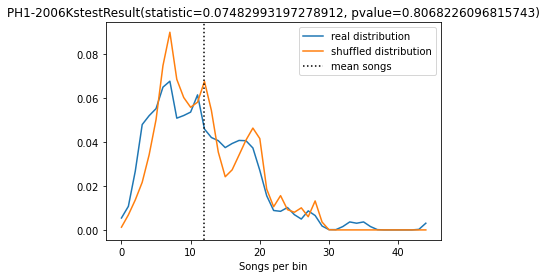

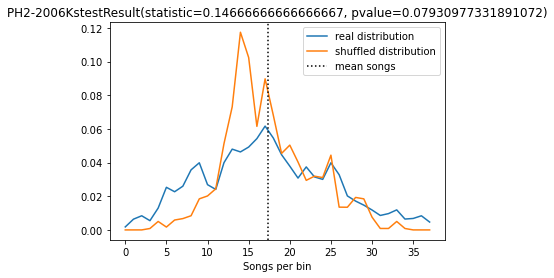

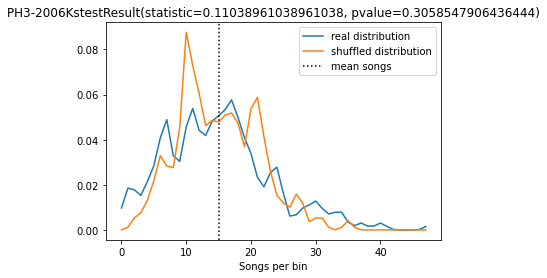

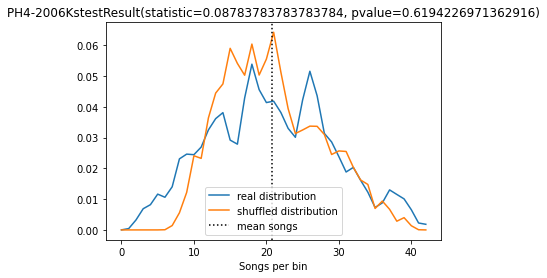

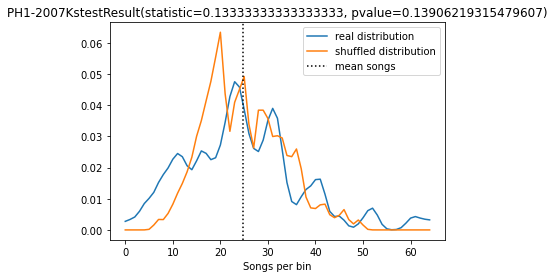

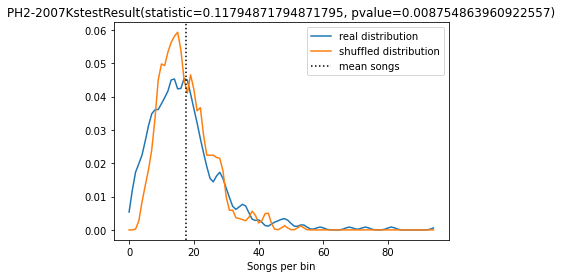

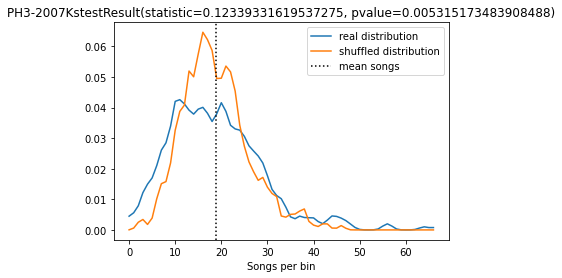

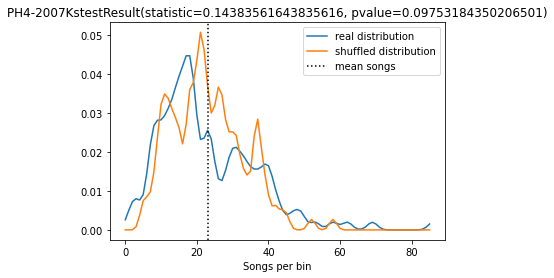

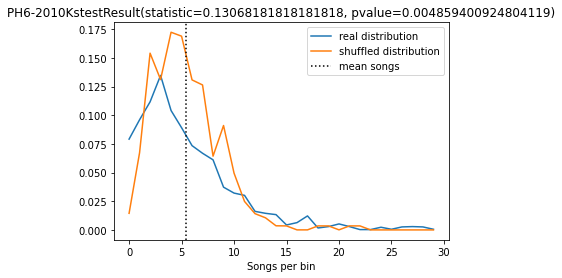

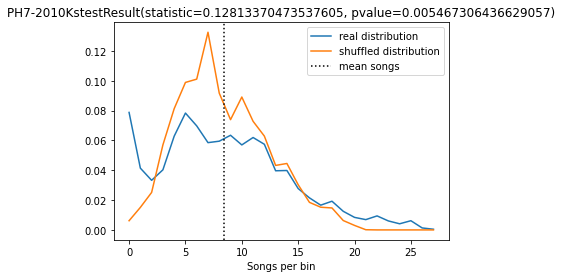

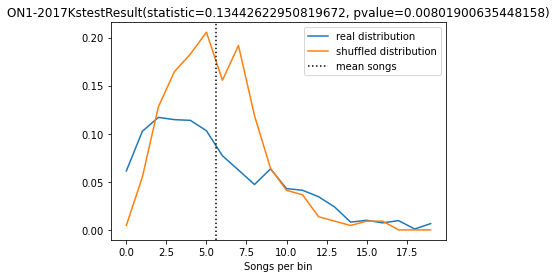

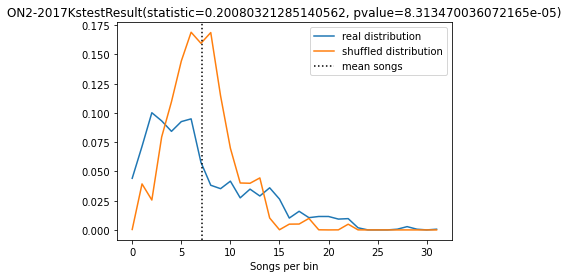

In [80]:
## Check all the aviaries for song vs non-song

n_copulations = []
song_stat = []
for a in range(len(metas)):
    n_males,n_females = metas[a].n_males,metas[a].n_females
    history_bins,[history_rate_bins,ts,window_indices] = bin_history(sorteds[a],historys[a],metas[a],
                                                                     window=300)

    
    cop_indices = get_cop_indices(copulations[a])
    cop_bin_indices = get_cop_bins(cop_indices,window_indices)
    
    straight_sum = np.sum(history_bins,axis=(1,2))
        
    shuffle_bins = shuffle_indy_bins(history_bins)
    shuffle_sum = np.sum(shuffle_bins,axis=(1,2))
    
    if len(cop_bin_indices) <= 1:
        print('no copulations')
        print(metas[a].name,cop_bin_indices)
        #continue
    print('n copulations:',len(cop_bin_indices)) 
    n_copulations.append(len(cop_bin_indices))
    if len(cop_bin_indices) > 1:
        cop_min,cop_max = cop_bin_indices[0],cop_bin_indices[-1]
        random_cop_indices = np.random.choice(np.arange(cop_min,cop_max),size=int(.5 * (cop_max-cop_min)),replace=False)

        cop_bins = history_bins[cop_bin_indices]
        cop_bins_m1 = history_bins[cop_bin_indices-1]
        cop_bins_shuffled = history_bins[random_cop_indices]
    
        cop_sum = np.array([np.sum])
    ## How precisely I should define "High-Song" bins is not obvious to me
    if False:
        hi_song_bins = history_bins[straight_sum > np.mean(straight_sum)] #np.mean(straight_sum)]
        hi_song_shuffle = shuffle_indy_bins(hi_song_bins)
    elif False:
        hi_song_bins = cop_bins_m1
        hi_song_shuffle = cop_bins_shuffled
    else:
        hi_song_bins = history_bins
        hi_song_shuffle = shuffle_indy_bins(hi_song_bins)
    """# Need to correct these for within high song windows, otherwise I'm just grabbing the same results

    undirected_straight = np.array([np.sum(np.diagonal(history_bins[i])) for i in range(len(history_bins))])
    undirected_shuffled = np.array([np.sum(np.diagonal(shuffle_bins[i])) for i in range(len(history_bins))])
    
    male_straight = np.sum(history_bins[:,n_females:,n_females:],axis=(1,2))
    female_straight = np.sum(history_bins[:,n_females:,:n_females],axis=(1,2))
    
    male_shuffled = np.sum(shuffle_bins[:,n_females:,n_females:],axis=(1,2))
    female_shuffled = np.sum(shuffle_bins[:,n_females:,:n_females],axis=(1,2))
    """
    
    undirected_straight = np.array([np.sum(np.diagonal(hi_song_bins[i,n_females:,n_females:])) for i in range(len(hi_song_bins))])
    undirected_shuffled = np.array([np.sum(np.diagonal(hi_song_shuffle[i,n_females:,n_females:])) for i in range(len(hi_song_bins))])                          
    
    unchatter_straight = np.array([np.sum(np.diagonal(hi_song_bins[i,:n_females,:n_females])) for i in range(len(hi_song_bins))])
    unchatter_shuffled = np.array([np.sum(np.diagonal(hi_song_shuffle[i,:n_females,:n_females])) for i in range(len(hi_song_bins))]) 
    
    male_straight = np.sum(hi_song_bins[:,n_females:,n_females:],axis=(1,2))
    female_straight = np.sum(hi_song_bins[:,n_females:,:n_females],axis=(1,2))
    
    male_shuffled = np.sum(hi_song_shuffle[:,n_females:,n_females:],axis=(1,2))
    female_shuffled = np.sum(hi_song_shuffle[:,n_females:,:n_females],axis=(1,2))
    
    all_straight = np.sum(hi_song_bins,axis=(1,2))
    all_shuffled = np.sum(hi_song_shuffle,axis=(1,2))
    
    male_presence = count_males(hi_song_bins,n_females)
    #male_presence_shuffled = shuffle_indy_bins(male_presence)
    male_presence_shuffled = count_males(hi_song_shuffle,n_females)
    male_counts = np.sum(male_presence,axis=1)
    male_counts_shuffled = np.sum(male_presence_shuffled,axis=1)
    
    
    print(metas[a].name)
    
    ## Plot it, if you feel like that
    if True:
        print(male_straight.shape,male_shuffled.shape)
        fig,ax = plt.subplots()
        straight_dist = gaussian_kde(male_straight,bw_method=.1)
        shuffle_dist = gaussian_kde(male_shuffled,bw_method=.1)

        #straight_dist = gaussian_kde(male_counts,bw_method=.01)
        #shuffle_dist = gaussian_kde(male_counts_shuffled,bw_method=.01)
        
        xs = np.arange(0,max(max(male_straight),max(male_shuffled)))

        
        ax.plot(xs,straight_dist(xs),label='real distribution')
        ax.plot(xs,shuffle_dist(xs),label='shuffled distribution')
        #ax.axvline(1)
        ax.axvline(np.mean(male_straight),color='black',label='mean songs',linestyle=':')
        #ax.axvline(np.median(male_straight),color='red')
        ax.set_title(metas[a].name + str(ks_2samp(male_straight,male_shuffled)))
        ax.set_xlabel('Songs per bin')
        ax.legend()
        fig.show()

    ## Need to actually chunk these into singing vs non-singing first
    #"""
    #print('n copulations:',np.sum(cop_bins))
    print('males:,',ks_2samp(male_counts,male_counts_shuffled))
        
    print('singing:',ks_2samp(straight_sum,shuffle_sum))
    print('high song bins:',len(male_straight),'/',len(straight_sum))
    print('male singing:',ks_2samp(male_straight,male_shuffled))

    print('undirected singing:',ks_2samp(undirected_straight,undirected_shuffled))
    print('undirected chatter:',ks_2samp(unchatter_straight,unchatter_shuffled))

    print('female singing:',ks_2samp(female_straight,female_shuffled))
    s_stat,s_p = ks_2samp(straight_sum,shuffle_sum)
    song_stat.append(s_stat)
    """ 
    print('all singing ttest:',ttest_ind(all_straight,all_shuffled))
    print('male singing (ttest):',ttest_ind(male_straight,male_shuffled))
    print('female singing (ttest):',ttest_ind(female_straight,female_shuffled))
    print('undirected (ttest):',ttest_ind(undirected_straight,undirected_shuffled))
    #"""
    print('')
    
#print(pearsonr(n_copulations,song_stat))

F_onewayResult(statistic=36.7441649146985, pvalue=1.5956843084536126e-74)


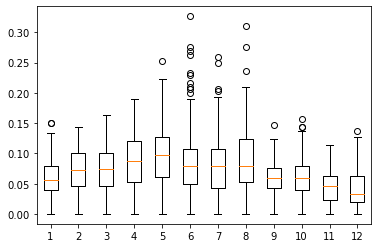

In [81]:
fig,ax = plt.subplots()
song_rates = []
male_rates = []
for a in range(len(metas)):
    n_males,n_females = metas[a].n_males,metas[a].n_females
    history_bins,[history_rate_bins,ts,window_indices] = bin_history(sorteds[a],historys[a],metas[a],
                                                                     window=300)
    aviary_song_rates = np.sum(history_rate_bins,axis=(1,2))
    male_song_rates = np.sum(history_rate_bins,axis=(2)).flatten()
    
    #ax.boxplot(aviary_song_rates,positions=[a]*len(aviary_song_rates))
    song_rates.append(aviary_song_rates)

ax.boxplot(song_rates)    
fig.show()

print(f_oneway(*song_rates))

In [82]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR

## Repeating the loop above, i wanted a fresh start
for a in range(len(metas)):
    n_males,n_females = metas[a].n_males,metas[a].n_females
    history_bins,[history_rate_bins,ts,window_indices] = bin_history(sorteds[a],historys[a],metas[a],window=200)
    
    cop_indices = get_cop_indices(copulations[a])
    cop_bin_indices = get_cop_bins(cop_indices,window_indices)
    
    ## Get predictable indices
    ## This isn't quite working...
    p = 2 # Prediction bins
    time_diff = ts[1:] - ts[:-1]
    pred_indices = time_diff < 300
    next_indices = np.hstack([False,pred_indices])
    pred_indices = np.hstack([pred_indices,False])
    
    predictors = history_bins[pred_indices]
    next_blocks = history_bins[next_indices]
    next_block_sum = np.sum(next_blocks,axis=(1,2))
    next_block_male2female = np.sum(next_blocks[:,n_females:,:n_females],axis=(1,2))
    X = np.reshape(predictors,[len(predictors),-1])
    y_fancy = np.reshape(next_blocks,[len(next_blocks),-1])
    #y = next_block_sum
    y = next_block_male2female
    """
    X = np.reshape(history_bins,[len(history_bins),-1])
    y = np.zeros(len(history_bins))
    
    if len(cop_bin_indices) < 5: 
        continue
    for c in cop_bin_indices:
        y[c] = 1

    ## Downsample so it's balanced
    useful_bins = sorted(np.hstack([np.random.choice(np.arange(len(X)),size=int(np.sum(y)),replace=False),
                             np.arange(len(X))[y==1]]))
    print(useful_bins)
    X = X[useful_bins]
    y = y[useful_bins]
    #"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    clf = LR(class_weight='balanced')
    #clf = RFC(class_weight='balanced')
    clf.fit(X_train,y_train)
    test_preds = clf.predict(X_test)
    shuffled_test = np.random.permutation(y_test)
    print(metas[a].name,np.sum(copulations[a]))
    print('classifier:',np.mean(np.abs(test_preds - y_test)),clf.score(X_test,y_test))
    print('shuffled:',np.mean(np.abs(test_preds - shuffled_test)),clf.score(X_test,shuffled_test))
    X_test_square = np.reshape(X_test,[len(X_test),metas[a].n_birds,metas[a].n_birds])
    y_heuristic = np.sum(X_test_square[:,n_females:,:n_females],axis=(1,2))
    print('tangent:',np.mean(np.abs(y_test - y_heuristic)),np.mean(y_heuristic == y_test))

## Tangent is the performance if you just use a very simple heuristic. 

PH1-2006 60.0
classifier: 2.6285714285714286 0.2
shuffled: 3.7142857142857144 0.14285714285714285
tangent: 3.0285714285714285 0.3142857142857143
PH2-2006 10.0
classifier: 2.2972972972972974 0.21621621621621623
shuffled: 3.0 0.1891891891891892
tangent: 2.4054054054054053 0.24324324324324326
PH3-2006 35.0
classifier: 2.6666666666666665 0.16666666666666666
shuffled: 3.3333333333333335 0.05555555555555555
tangent: 2.5833333333333335 0.2222222222222222
PH4-2006 10.0
classifier: 3.2222222222222223 0.1111111111111111
shuffled: 3.888888888888889 0.05555555555555555
tangent: 2.5555555555555554 0.2777777777777778
PH1-2007 0.0
classifier: 2.5135135135135136 0.21621621621621623
shuffled: 4.081081081081081 0.08108108108108109
tangent: 2.7567567567567566 0.2972972972972973
PH2-2007 50.0
classifier: 2.8297872340425534 0.13829787234042554
shuffled: 3.106382978723404 0.1276595744680851
tangent: 2.5106382978723403 0.19148936170212766
PH3-2007 70.0
classifier: 2.6702127659574466 0.14893617021276595
shuff

In [83]:
## Using the best result above (aviary #3) how far does it go? 

## This basically fails, presumably on account of not removing the bins, so instead lets focus on predictability. 
history_bins,[history_rate_bins,ts,window_indices] = bin_history(sorteds[a],historys[a],metas[a],window=200)
iterations = 10

max_shift = 5
scores = np.zeros([max_shift,iterations])
rand_scores = np.zeros_like(scores)
for bin_shift in range(max_shift):
    if bin_shift == 0:
        predictors = history_bins
    else:
        predictors = history_bins[:-bin_shift]
    next_blocks = history_bins[bin_shift:]
    next_block_sum = np.sum(next_blocks,axis=(1,2))
    X = np.reshape(predictors,[len(predictors),-1])
    y = next_block_sum

    for i in range(iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
        #clf = LR()
        clf = RFR()
        clf.fit(X_train,y_train)
        test_preds = clf.predict(X_test)
        shuffled_test = np.random.permutation(y_test)
        
        #print(np.mean(np.abs(test_preds - y_test)),clf.score(X_test,y_test))
        #print(np.mean(np.abs(test_preds - shuffled_test)),clf.score(X_test,shuffled_test),'\n')
        scores[bin_shift,i] = clf.score(X_test,y_test)
        rand_scores[bin_shift,i] = clf.score(X_test,shuffled_test)

In [119]:
## Identify bins that I can use, based on a) number of bins to use, b) how far into the future
# First, calculate time difference between bin starts
def predict_future(history_bins,ts,meta,pred_window=1,bin_skips=0,window=100,classifier=RFC(),):
    n_females = meta.n_females
    ## Do any desired preprocessing here
    preproc_X = np.sum(history_bins[:,n_females:,n_females:],axis=(1,2))
    preproc_y = np.sum(history_bins[:,n_females:,n_females:],axis=(1,2))
    
    predictors,predictions = [],[]
    ## Define some parameters
    p = pred_window # Addition prediction Bins
    j = bin_skips + 1 # distance after last predictor to predict
 
    
    time_diff = ts[1:] - ts[:-1]
    pred_indices = np.zeros_like(time_diff)
    ## Identify indices that work for the condition
    for i in range(len(time_diff)-p-j):
        view_window = time_diff[i:i+p+j]
        if max(view_window) <= window*2:
            pred_indices[i] = 1
    ## Using those indices, build X and y for classifier/regressor
    for i in range(len(time_diff)):
        if pred_indices[i] == 1:
            predictors.append(preproc_X[i:i+p])
            predictions.append(preproc_y[i+j])
    X = np.array(predictors)
    y = np.array(predictions)  
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    #clf = LR()
    clf = classifier
    clf.fit(X_train,y_train)
    

    return clf,[X_train,X_test,y_train,y_test]

In [121]:
## Check all aviaries for predictability

for a in range(len(metas)):
    history_bins,[history_rate_bins,ts,window_indices]= bin_history(sorteds[a],
                                                                    historys[a],metas[a],window=100)

    """
    clf,clf_sets = predict_future(history_bins,ts,metas[a],pred_window=1,bin_skips=0,window=100)
    print(clf.score(clf_sets[1],clf_sets[3]))
    print(clf.score(clf_sets[1],np.random.permutation(clf_sets[3])))
    print(len(clf_sets[0]))
    """
    iterations = 30
    clf_scores,random_scores = [],[]
    for i in range(iterations):
        clf,clf_sets = predict_future(history_bins,ts,metas[a],
                                      pred_window=3,bin_skips=2,window=100,classifier=LR())
        
        
        y_true = clf.predict(clf_sets[1])
        #print(y,clf_sets[3])
        r_score,_ = pearsonr(y_true,clf_sets[3])
        score = clf.score(clf_sets[1],clf_sets[3])
        
        ## Refit with shuffled labels
        clf.fit(clf_sets[0],np.random.permutation(clf_sets[2]))
        y_shuffle = clf.predict(clf_sets[1])
        random_score = clf.score(clf_sets[1],clf_sets[3])
        random_r_score,_ = pearsonr(y_shuffle,clf_sets[3])
        
        clf_scores.append(r_score)
        random_scores.append(random_r_score)

    print('Aviary:',metas[a].name)
    print('Mean Classifer vs random:',np.nanmean(clf_scores),np.nanmean(random_scores))
    #print(clf_scores,random_scores)
    print(ttest_ind(clf_scores,random_scores,nan_policy='omit'))
    print()
# I.e. find a bin that is followed by at least two bins (give me a bunch of indices i)
## Two bins here is specific to the two->1 case, if it's two->predict in two steps, I need 3
### The general case is i : i+n_predictors + n_skips need to be in same window (i.e. no gaps >bin size)
# Grap the pairs of bins (that's just i:i+1), maybe do some pre-processing here, even heuristics
# Grap the bins to be predicted (thats i+2)

Aviary: PH1-2006
Mean Classifer vs random: 0.3602075316300829 0.08166947091074174
Ttest_indResult(statistic=3.976412777101333, pvalue=0.00019643973229330455)

Aviary: PH2-2006
Mean Classifer vs random: -0.0020791540504748233 0.05533514109821992
Ttest_indResult(statistic=-1.2202160279535943, pvalue=0.2273211284854823)

Aviary: PH3-2006
Mean Classifer vs random: 0.3650827150218822 -0.16210868867298397
Ttest_indResult(statistic=9.403252242309035, pvalue=2.8850275229547386e-13)

Aviary: PH4-2006
Mean Classifer vs random: 0.21101354912887502 0.04401162421218675
Ttest_indResult(statistic=2.7663764366877563, pvalue=0.0075917513780629714)

Aviary: PH1-2007
Mean Classifer vs random: 0.19214897954847157 0.07798253347654051
Ttest_indResult(statistic=2.006349011202165, pvalue=0.04948946230862157)

Aviary: PH2-2007
Mean Classifer vs random: 0.47839653554502426 0.10421388745885288
Ttest_indResult(statistic=5.993959017374156, pvalue=1.3945788725722775e-07)

Aviary: PH3-2007
Mean Classifer vs random: 

In [118]:
## Comparing number of eggs to magnitude of p-value
for i in range(4):
    egg_array = all_eggs[i]
    egg_cutoff = egg_cutoffs[i]
    print('n_eggs:',np.sum(egg_array[:egg_cutoff]))
    print('eggs_by_day:',np.sum(egg_array[:egg_cutoff],axis=(1,2)))
    print('dates:',[day_of_year(d) for d in all_datestamps[i][:egg_cutoff]])
    print('n_females,males:',metas[i].n_females, metas[i].n_males)


print(pearsonr([15,8,21,8],[6,3,11,0]))

from scipy.stats import spearmanr

print(spearmanr([15,8,21,8],[6,3,11,0]))

n_eggs: 15.0
eggs_by_day: [1. 0. 2. 3. 3. 1. 3. 2.]
dates: [125, 126, 127, 128, 129, 130, 131, 132]
n_females,males: 12 5
n_eggs: 8.0
eggs_by_day: [1. 1. 1. 2. 2. 1.]
dates: [127, 128, 129, 130, 131, 132]
n_females,males: 13 14
n_eggs: 21.0
eggs_by_day: [1. 1. 2. 5. 4. 5. 3.]
dates: [126, 127, 128, 129, 130, 131, 132]
n_females,males: 11 6
n_eggs: 8.0
eggs_by_day: [1. 2. 2. 1. 0. 2.]
dates: [127, 128, 129, 130, 131, 132]
n_females,males: 13 16
(0.9631766693360904, 0.03682333066390964)
SpearmanrResult(correlation=0.9486832980505139, pvalue=0.051316701949486114)


# So far, this is promising

In the first four aviaries checked, egg count almost perfectly correlates with predictability. 

I want to take a step back though and look at 
- Egg number over the course of the season
- Predictability over the course of the season

- Predictability as a function of bird number

To make sure we're not just getting a spurious correlation. 

5


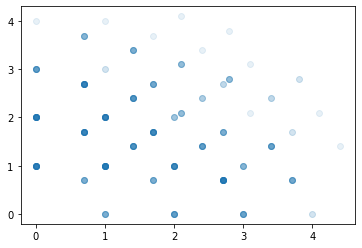

In [158]:
# Egg counts over the course of the season (all aviaries) are up above. 

# Lets fix prediction first. 

# Define the group state as a point in space
a = 0
history_bins,[history_rate_bins,ts,window_indices]= bin_history(sorteds[a],historys[a],metas[a],window=100)
male_states = np.zeros([len(history_bins),metas[a].n_males,2])

n_males,n_females = metas[a].n_males,metas[a].n_females
for b in range(len(history_bins)):
    for m in range(metas[a].n_males):
        m_songs = np.sum(history_bins[b,m + n_females,n_females:])
        f_songs = np.sum(history_bins[b,m+n_females,:n_females])
        u_songs = history_bins[b,m + n_females,m+n_females]
        m_songs = m_songs - u_songs
        if f_songs > 0:
            m_state = [0,1]
        elif m_songs > 0:
            m_state = [1,0]
        elif u_songs > 0:
            m_state = [.7,.7]
        else:
            m_state = [0,0]
        male_states[b,m] = m_state

fig,ax = plt.subplots()
ax.scatter(np.sum(male_states[:,:,0],1),np.sum(male_states[:,:,1],1),alpha=.1)
fig.show()

print(n_males)

(390, 2)


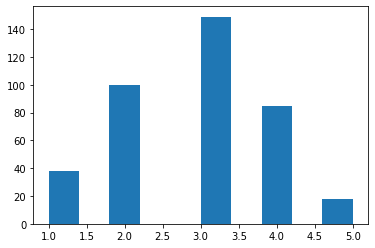

In [157]:
fig,ax = plt.subplots()

dists = np.sum(points,axis=1)
print(points.shape)

ax.hist(dists)

fig.show()

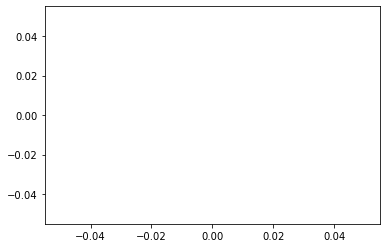

In [159]:
from matplotlib.animation import FuncAnimation
## This works, but not in jupyter, because of my weird conda build. 

points = np.sum(male_states,axis=1)

fig, ax = plt.subplots()

#scat = ax.scatter([],[])
line, = ax.plot([],[])

def init0():
    ax.set_xlim(-0.1,4.1)
    ax.set_ylim(-0.1,4.1)
    return scat,

def init():
    line.set_data([0,0],[.1,.1])
    ax.set_xlim(-0.1,4.1)
    ax.set_ylim(-0.1,4.1)
    return (line,)

def animate(i):
    x,y = points[i]
    line.set_data(x,y)
    return line,

anim = FuncAnimation(fig,animate,frames=range(len(points)),init_func=init, interval=20)

#anim.save('points.gif',writer='imagemagick')
plt.show()


In [153]:
from matplotlib import rc
rc('animation',html='html5')

In [160]:
np.save('points.npy',points)

## Old Stuff:

In [142]:
print(points)

[[1.5 1.5]
 [1.5 0.5]
 [1.5 1.5]
 [2.  2. ]
 [0.5 1.5]
 [2.  1. ]
 [2.  2. ]
 [1.5 2.5]
 [1.5 1.5]
 [1.5 0.5]
 [1.  1. ]
 [1.5 0.5]
 [1.  1. ]
 [2.  2. ]
 [1.5 2.5]
 [3.5 1.5]
 [2.  1. ]
 [1.  1. ]
 [1.  1. ]
 [3.  1. ]
 [1.5 1.5]
 [1.  3. ]
 [1.5 1.5]
 [1.  1. ]
 [1.  1. ]
 [1.  1. ]
 [0.5 1.5]
 [1.  1. ]
 [0.5 0.5]
 [1.5 0.5]
 [3.  2. ]
 [2.  1. ]
 [2.  2. ]
 [3.  2. ]
 [2.  2. ]
 [2.  2. ]
 [1.  2. ]
 [1.  1. ]
 [0.5 0.5]
 [2.5 0.5]
 [3.  1. ]
 [3.  1. ]
 [2.  2. ]
 [0.5 0.5]
 [2.  1. ]
 [2.  2. ]
 [1.  1. ]
 [0.5 1.5]
 [0.5 1.5]
 [0.5 1.5]
 [0.5 2.5]
 [1.5 1.5]
 [1.  1. ]
 [1.  2. ]
 [2.5 0.5]
 [2.  0. ]
 [2.5 0.5]
 [2.5 0.5]
 [3.  1. ]
 [1.5 1.5]
 [0.  1. ]
 [3.  0. ]
 [1.  2. ]
 [0.  1. ]
 [0.5 0.5]
 [1.5 2.5]
 [1.  3. ]
 [2.5 0.5]
 [1.5 1.5]
 [1.  1. ]
 [2.  0. ]
 [2.  1. ]
 [0.  1. ]
 [1.5 1.5]
 [3.  1. ]
 [1.5 2.5]
 [2.5 0.5]
 [1.  2. ]
 [2.  0. ]
 [2.5 0.5]
 [1.  1. ]
 [2.  1. ]
 [2.5 0.5]
 [1.5 0.5]
 [3.  0. ]
 [2.5 0.5]
 [2.  1. ]
 [2.5 0.5]
 [1.  1. ]
 [1.  2. ]
 [2.  1. ]

In [ ]:
## Check for predictability with variable parameters

a = 2
p=2
b=0
for p in [1,2,3,4]:
    history_bins,[history_rate_bins,ts,window_indices]= bin_history(sorteds[a],historys[a],metas[a],window=100)

    """
    clf,clf_sets = predict_future(history_bins,ts,metas[a],pred_window=1,bin_skips=0,window=100)
    print(clf.score(clf_sets[1],clf_sets[3]))
    print(clf.score(clf_sets[1],np.random.permutation(clf_sets[3])))
    print(len(clf_sets[0]))
    """
    iterations = 30
    clf_scores,random_scores = [],[]
    for i in range(iterations):
        clf,clf_sets = predict_future(history_bins,ts,
                        metas[a],pred_window=p,bin_skips=b,window=100,classifier=LR())
        clf_scores.append(clf.score(clf_sets[1],clf_sets[3]))
        random_scores.append(clf.score(clf_sets[1],np.random.permutation(clf_sets[3])))
    print('pred window:',p)
    print('n skips=',b)
    print('Mean Classifer vs random:',np.mean(clf_scores),np.mean(random_scores))
    print(ttest_ind(clf_scores,random_scores))
    print('dataset size:',len(clf_sets[0]))
    print()

In [ ]:
fig,ax = plt.subplots()
ax.hist(clf_scores,label='classifier performance')
ax.hist(random_scores,label='shuffled performance')

fig.legend()
fig.show()

In [ ]:
fig,ax = plt.subplots()

ax.bar(range(max_shift),np.mean(scores,1),yerr=np.std(scores,1),width=.4)
ax.bar(np.arange(max_shift) +.4,np.mean(rand_scores,1),yerr=np.std(scores,1),width=.4)
fig.show()

In [ ]:
straight_dist = gaussian_kde(straight_sum,bw_method=.1)
shuffle_dist = gaussian_kde(shuffle_sum)
fig,ax = plt.subplots()
xs = np.linspace(min(straight_sum),max(straight_sum),50)


ax.plot(xs,straight_dist(xs))
ax.plot(xs,shuffle_dist(xs))
ax.axvline(np.mean(straight_sum))
ax.axvline(np.median(straight_sum),color='red')

fig.show()

In [ ]:
#print(window_indices)


shuffle_bins = shuffle_indy_bins(history_bins)
print(shuffle_bins.shape)

shuffle_sum = np.sum(shuffle_bins,axis=(1,2))
straight_sum = np.sum(history_bins,axis=(1,2))
print(straight_sum.shape)

fig,ax = plt.subplots()
ax.hist(straight_sum,alpha=.5)
ax.hist(shuffle_sum,alpha=.5)


fig.show()


print(ks_2samp(straight_sum,shuffle_sum))

In [ ]:
#print(window_indices)
all_counts,window_indices = count_sequence(sorteds[a],metas[a],window=200,plot_me=-2,g_kernel = .1,t0=-234)
all_the_data = []
for i0,ix in window_indices:
    n_females = metas[-1].n_females
    all_the_data.append(np.sum(historys[a][i0:ix,n_females:],0).flatten())
    
all_the_data = np.array(all_the_data)
print(all_the_data.shape)

fig,ax = plt.subplots()
ax.imshow(all_the_data[1].reshape([metas[s].n_males,metas[s].n_birds]))

print(np.unique(all_the_data[1]))
fig.show()

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
X = all_the_data
print(X.shape[1])
pca = PCA(n_components=X.shape[0])
pca.fit(X)
print(pca.explained_variance_ratio_[:10])
#print(pca.singular_values_)

In [ ]:
fig,ax = plt.subplots()
summed_variance = np.ones(len(X))
for i in range(len(X)):
    summed_variance[i] = np.sum(pca.explained_variance_ratio_[:i])
ax.scatter(range(len(X)),pca.explained_variance_ratio_,label='Variance explained')
ax.scatter(range(len(X)),summed_variance,label='Summed Variance Explained')
ax.axvline(np.argmax(summed_variance > .5))
ax.set_ylim([0,.5])
fig.legend()
fig.show()

In [ ]:
y = pca.transform(X)

print(pca.explained_variance_ratio_[:10])
#print(pca.components_[0])
fig,ax = plt.subplots()
ax.scatter(range(len(pca.components_[0])),pca.components_[0],alpha=.4)
ax.scatter(range(len(pca.components_[1])),pca.components_[1],alpha=.4)
fig.show()

fig,ax = plt.subplots()
heatmap = np.reshape(pca.components_[0],[metas[-1].n_males,metas[-1].n_birds])
ax.imshow(heatmap)
fig.show()
                     

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

import umap
import numba

print(numba.__version__)
data = np.random.rand(800, 4)
fit = umap.UMAP()
u = fit.fit_transform(data)

In [ ]:
for a in range(len(metas)):

    all_counts,window_indices = count_sequence(sorteds[a],metas[a],window=200,plot_me=-2,g_kernel = .1,t0=-234)
    all_the_data = []
    for i0,ix in window_indices:
        n_females = metas[a].n_females
        all_the_data.append(np.sum(historys[a][i0:ix,n_females:],0).flatten())
    
    all_counts = np.array(all_counts)
    clean_counts = all_counts[:,~np.isnan(all_counts[0])]
    normed_counts = np.divide(clean_counts.transpose(),np.nanmax(clean_counts,1)).transpose()

    X = np.array(all_the_data)
    print('Shape:',X.shape)
    pca = PCA(n_components=20)
    X = pca.fit_transform(X)
    print(sum(pca.explained_variance_ratio_),pca.explained_variance_ratio_)

    fig,ax = plt.subplots()
    ax.scatter(X[:,0],X[:,1],c=normed_counts.transpose())
    fig.show()
    fit = umap.UMAP()
    #scaled_X = StandardScaler().fit_transform(X.transpose())


    u = fit.fit_transform(X)

    fig,ax = plt.subplots()
    ax.scatter(u[:,0],u[:,1],alpha=.6,marker='.',c=normed_counts.transpose())
    fig.show()


In [ ]:
all_counts = np.array(all_counts)
print(all_counts.shape)
#print(all_counts[:,~np.isnan(all_counts[0])].shape)
clean_counts = all_counts[:,~np.isnan(all_counts[0])]
print(clean_counts.shape)
print(np.nanmax(all_counts,1))
normed_counts = np.divide(clean_counts.transpose(),np.nanmax(clean_counts,1)).transpose()


In [ ]:
fit = umap.UMAP(min_dist=.5,n_neighbors=10)
u = fit.fit_transform(normed_counts.transpose())

fig,ax = plt.subplots()
ax.scatter(u[:,0],u[:,1],c=normed_counts.transpose())
fig.show()

In [ ]:
fit = umap.UMAP(min_dist=.1)
#scaled_X = StandardScaler().fit_transform(X.transpose())
u = fit.fit_transform(X)
print(u.shape)
fig,ax = plt.subplots()
ax.scatter(u[:,0],u[:,1],alpha=.8,marker='o',c=normed_counts.transpose())
fig.show()

In [ ]:
from scipy.stats import kde
print(sorteds[-1][0])
%matplotlib inline

_ = count_sequence(sorteds[-1],metas[-1],window=200,plot_me = 2,g_kernel=3,t0=-230)

In [ ]:
np.array(all_counts_m) > np.array(all_counts_f)

for key, group in itertools.groupby( 1 - male_high )

In [ ]:

condition = [True,True,True,False,False,True,True,False,True]
male_high = np.array(all_counts_m) > np.array(all_counts_f)

m_lengths = [ sum( 1 for _ in group ) for key, group in itertools.groupby( male_high ) if key ]
f_lengths = [ sum( 1 for _ in group ) for key, group in itertools.groupby( 1 - male_high ) if key ]


fig,ax = plt.subplots()
ax.hist(m_lengths)
ax.hist(f_lengths)
fig.show()

## Plots start here

In [ ]:
## This cell does a lot of the analysis necessary for the old fig 4, but some of the other figures need this too.
# This should really probably be a function
%matplotlib inline

## Plots a line, useful in some placese, although I don't use it that much anymore. 
def plot_mb(ax,slope,intercept, **kwargs):
    ax = ax
    xlim = ax.get_xlim()
    x0 = xlim[0]
    y0 = intercept + slope * x0
    x1 = xlim[1]
    y1 = intercept + slope * x1
    return ax.plot([x0,x1],[y0,y1], **kwargs)

all_songs_norm = np.array([])
all_rattle_probs = np.empty_like(all_songs_norm)
all_leave_probs = np.empty_like(all_songs_norm)
all_pairbond_counts = np.empty_like(all_songs_norm)

all_data_by_bird = []
all_the_bars = np.array([])
all_the_errs = np.array([])
all_the_stds = np.array([])

SKEW = True
## Loop through all the aviaries and grab statistics. This would be useful if I wanted to get other things too.
for a in range(len(historys)):
    aviary_index = a

    history_data = historys[aviary_index]
    sorted_data = sorteds[aviary_index]
    meta_data = metas[aviary_index]

    
    f_calls, f_leaves, summed_investment,_ = f_attention(history_data, sorted_data, meta_data)
    f_calls[np.transpose(summed_investment) == 0] = 0
    
    #f_calls[f_calls <= 1] = 0
    #print(f_calls)
    #print(f_leaves)
    #print(history_data.sum(0)[meta_data.n_females:,:meta_data.n_females])

    #summed_investment = history_data[:meta_data.cutoff].sum(0)[meta_data.n_females:,:meta_data.n_females] 
    summed_investment = history_data.sum(0)[meta_data.n_females:,:meta_data.n_females]
    normed_investment = np.empty([meta_data.n_females,meta_data.n_males])
    normed_calls = np.empty_like(normed_investment)
    normed_leaves = np.empty_like(normed_investment)
    for f in range(meta_data.n_females):
        normed_investment[f] = summed_investment[:,f] / summed_investment[:,f].sum()
        normed_calls[f] = f_calls[f] / (f_calls[f].sum() + .0001)
        normed_leaves[f] = f_leaves[f] / (f_leaves[f].sum() + .0001)


    aviary = meta_data.name
    males = meta_data.m_ids
    females = meta_data.f_ids

    pairbonds = np.nanargmax(np.transpose(summed_investment),axis=1)
    
    sorted_pair_index = np.argsort(pairbonds)
    sorted_pairbonds = pairbonds[sorted_pair_index]    

    #song_transpose = np.transpose(summed_investment + .0001) #[sorted_pair_index]
    song_transpose = np.transpose(summed_investment) #[sorted_pair_index]

    vice_transpose = np.zeros([meta_data.n_females,meta_data.n_males-1])
    for f in range(meta_data.n_females):
        vice_transpose[f] = song_transpose[f,np.arange(meta_data.n_males) != pairbonds[f]]

    vice_pairbonds = np.nanargmax(vice_transpose,axis=1)
    #print(vice_pairbonds)
    #rattle_chance = (f_calls / (song_transpose + .0001))[sorted_pair_index]
    rattle_chance = (f_calls / (song_transpose))[sorted_pair_index]
    
    rattle_chance_1 = np.copy(rattle_chance)
    rattle_chance_5 = np.copy(rattle_chance)
    
    f_calls_1 = np.copy(f_calls)
    f_calls_5 = np.copy(f_calls)
    ## For some weird reason, this doesn't work if you don't round song_transpose...I don't like that.
    f_calls_1[song_transpose <= 1] = np.nan
    f_calls_5[song_transpose <= 5] = np.nan
    
    #print(aviary)
    #print(f_calls)
    #print(f_calls_1)
    #print(rattle_chance)
    #print(song_transpose)
    
    rattle_chance_1[song_transpose <= 1] = np.nan
    rattle_chance_5[song_transpose <= 5] = np.nan

    #leave_chance = (f_leaves / (np.transpose(summed_investment + .0001)))[sorted_pair_index]
    leave_chance = (f_leaves / (np.transpose(summed_investment)))[sorted_pair_index]
    
    rattle_chance[rattle_chance >= 1] = 1
    leave_chance[leave_chance >= 1] = 1

    rattle_pairs = np.zeros_like(rattle_chance)
    leave_pairs = np.zeros_like(leave_chance)

    #print(np.shape(summed_investment))
    for f in range(len(sorted_pairbonds)):
        rattle_pairs[f,sorted_pairbonds[f]] = rattle_chance[f,sorted_pairbonds[f]]
        leave_pairs[f,sorted_pairbonds[f]] = leave_chance[f,sorted_pairbonds[f]]


    ## Make it easy to show 0's as white
    rattle_chance_skew = np.copy(rattle_chance)
    summed_investment_skew = np.copy(summed_investment)
    f_calls_skew = np.copy(f_calls)
    normed_calls_skew = np.copy(normed_calls)
    leave_chance_skew = np.copy(leave_chance)

    if SKEW:
        rattle_chance_skew[np.transpose(summed_investment)[sorted_pair_index] == 0] = np.nan
        leave_chance_skew[np.transpose(summed_investment)[sorted_pair_index] == 0] = np.nan
        normed_calls_skew[normed_calls == 0] = np.nan
        summed_investment_skew[summed_investment == 0] = np.nan
        f_calls_skew[f_calls == 0] = np.nan

    male_rattle_probs = np.nanmean(rattle_chance_skew,0)
    male_leave_probs = np.nanmean(leave_chance_skew,0)
    male_rattle_std = np.nanstd(rattle_chance_skew,0)
    male_leave_std = np.nanstd(leave_chance_skew,0)

    counted_index, counted_counts = np.unique(sorted_pairbonds, return_counts=True)

    pairbond_counts = np.zeros([meta_data.n_males])
    for m in range(meta_data.n_males):
        if m in counted_index:
            i = np.where(counted_index == m)[0]
            pairbond_counts[m] = counted_counts[i]

    counter_song = np.sum(history_data[:meta_data.cutoff],0)[meta_data.n_females:,meta_data.n_females:]
    sexy_song = np.sum(history_data[:meta_data.cutoff],0)[meta_data.n_females:,:meta_data.n_females]

    song_by_male = np.sum(counter_song,1)

    song_by_male_norm = song_by_male / np.sum(song_by_male)
    song_by_male_norm = np.round(song_by_male_norm,3)
    #print(song_by_male_norm,song_by_male_norm.sum())
    all_songs_norm = np.append(all_songs_norm,song_by_male_norm)
    all_rattle_probs = np.append(all_rattle_probs,male_rattle_probs)
    all_leave_probs = np.append(all_leave_probs,male_leave_probs)
    all_pairbond_counts = np.append(all_pairbond_counts,pairbond_counts)

    
    ## Do all that other stuff: 
    pairbond_probs = np.zeros(meta_data.n_females)

    #print(rattle_chance)
    #print(pairbonds,sorted_pair_index)
    #sorted_pairbonds = pairbonds[sorted_pair_index]
    other_rattles = np.zeros([meta_data.n_females,meta_data.n_males - 1])
    other_rattles_1 = np.zeros_like(other_rattles)
    other_rattles_5 = np.zeros_like(other_rattles)
    other_probs = np.zeros_like(other_rattles)
    other_probs_1 = np.zeros_like(other_rattles)
    other_probs_5 = np.zeros_like(other_rattles)

    pairbond_probs = rattle_chance[np.arange(meta_data.n_females),sorted_pairbonds]


    for f in range(meta_data.n_females):
        all_probs = rattle_chance[f,:]
        all_probs_1 = rattle_chance_1[f,:]
        all_probs_5 = rattle_chance_5[f,:]

        all_rattles = f_calls[sorted_pair_index]
        f_rattles = np.array([x for i,x in enumerate(all_rattles[f]) if i!=sorted_pairbonds[f]])
        f_rattles_1 = np.array([x for i,x in enumerate(f_calls_1[sorted_pair_index][f]) if i!=sorted_pairbonds[f]])
        f_rattles_5 = np.array([x for i,x in enumerate(f_calls_5[sorted_pair_index][f]) if i!=sorted_pairbonds[f]])
        f_probs = np.array([x for i,x in enumerate(all_probs) if i!=sorted_pairbonds[f]])
        other_probs_1[f] = np.array([x for i,x in enumerate(all_probs_1) if i!=sorted_pairbonds[f]])
        other_probs_5[f] = np.array([x for i,x in enumerate(all_probs_5) if i!=sorted_pairbonds[f]])
        other_rattles[f] = f_rattles
        other_rattles_1[f] = f_rattles_1
        other_rattles_5[f] = f_rattles_5
        other_probs[f] = f_probs


    try:
        vicebonds = np.nanargmax(other_rattles,axis=1)
    except:
        #print('all nan slice found')
        
        vicebonds = np.argmax(np.nan_to_num(other_rattles,copy=True),axis=1)
    try:
        vicebonds_1 = np.nanargmax(other_rattles_5,axis=1)
    except:
        #print('all nan slice found (no singing)')
        vicebonds_1 = np.argmax(np.nan_to_num(other_rattles_5,copy=True),axis=1)
    #print(vicebonds_1)
    vicebonds_1 = vice_pairbonds
    vicebonds = vice_pairbonds

    
    #print('calls,calls_!',f_calls[sorted_pair_index],f_calls_1[sorted_pair_index])
    #print('other rattles,other_rattles1:',other_rattles,other_rattles_1)
    #print('vice,vice_1',vicebonds,vicebonds_1)    
    #print(sorted_pairbonds,vicebonds,vicebonds_1)
    
    #print(other_rattles.shape)
    vice_rattles_1 = other_rattles[np.arange(meta_data.n_females),vicebonds_1]
    vice_probs_1 = other_probs[np.arange(meta_data.n_females),vicebonds_1]

    
    vice_rattles = other_rattles[np.arange(meta_data.n_females),vicebonds]
    vice_probs = other_probs[np.arange(meta_data.n_females),vicebonds]

    #print('vice-songs in aviary',aviary)
    for f in range(meta_data.n_females):
        #print(song_transpose[f,vicebonds[f]]) 
        #print(song_transpose[f,pairbonds[f]])
        if song_transpose[f,pairbonds[f]] < 10:
            pairbond_probs[f] = np.nan
        if song_transpose[f,vicebonds_1[f]] == 0:
            vice_rattles_1[f] = np.nan
            vice_probs_1[f] = np.nan
        if song_transpose[f,vicebonds[f]] == 0:
            vice_rattles[f] = np.nan
            vice_probs[f] = np.nan
    #print('Probabilites (song,vice,vice_1):')
    #print(song_transpose[sorted_pair_index])
    #print(vice_probs)
    #print(vice_probs_1)
    #print(f_calls_1[sorted_pair_index])
    
    mean_vice_probs = np.mean(vice_probs)
    std_vice_probs = np.std(vice_probs)
    sem_vice_probs = std_vice_probs / np.sqrt(len(vice_probs))
    
    mean_vice_probs_1 = np.nanmean(vice_probs_1)
    std_vice_probs_1 = np.nanstd(vice_probs_1)
    sem_vice_probs_1 = std_vice_probs_1 / np.sqrt(len(vice_probs_1))
    
    mean_other_probs = np.mean(np.mean(other_probs,1))
    std_other_probs = np.std(np.mean(other_probs,1))
    sem_other_probs = std_other_probs / np.sqrt(len(other_probs))

    mean_other_probs_1 = np.nanmean(other_probs_1)
    std_other_probs_1 = np.nanstd(other_probs_1)
    sem_other_probs_1 = std_other_probs_1 / np.sqrt(len(other_probs_1))
 
    mean_other_probs_5 = np.nanmean(other_probs_5)
    std_other_probs_5 = np.nanstd(other_probs_5)
    sem_other_probs_5 = std_other_probs_5 / np.sqrt(len(other_probs_5))
    
    mean_pairbond_probs = np.nanmean(pairbond_probs)
    std_pairbond_probs = np.nanstd(pairbond_probs)
    sem_pairbond_probs = std_pairbond_probs / np.sqrt(np.sum(~np.isnan(pairbond_probs)))

    data_by_bird = [pairbond_probs,vice_probs_1,np.nanmean(other_probs_1,0)]
    all_data_by_bird.append(data_by_bird)
    data_to_plot = np.array([mean_pairbond_probs,mean_vice_probs,mean_vice_probs_1,mean_other_probs_1,mean_other_probs])
    
    stds = np.array([std_pairbond_probs, std_vice_probs, std_vice_probs_1, std_other_probs_1, std_other_probs])
    yerrs = np.array([sem_pairbond_probs, sem_vice_probs, sem_vice_probs_1, sem_other_probs_1, sem_other_probs])
    
    all_the_bars = np.append(all_the_bars,data_to_plot)
    all_the_stds = np.append(all_the_stds,stds)
    all_the_errs = np.append(all_the_errs,yerrs * 2)

print('Done')

In [ ]:
## A little bit of day organization
first_day = datetime.strptime(str(2006)+'-'+ day_list[0],'20%y-%m-%d').timetuple().tm_yday
last_day = datetime.strptime(str(2006)+'-'+ day_list[-1],'20%y-%m-%d').timetuple().tm_yday


days_of_year = np.arange(first_day,last_day)
day_list_year = np.empty(len(day_list))
for d in range(len(day_list)):    
    day_of_year = datetime.strptime(str(2010)+'-'+ day_list[d],'20%y-%m-%d').timetuple().tm_yday
    day_list_year[d] = day_of_year

In [ ]:
## LOTS of code to plot fig 4

n_aviaries = len(all_data_by_bird)
aviary_cmap = cm.get_cmap('viridis')

pb_color = aviary_cmap(.3)
npb_color = aviary_cmap(.75)

#fig,(ax,ax2,ax3,ax4) = plt.subplots(1,4)

fig,(ax,ax1)= plt.subplots(2,1)
#ax1 = ax.twinx()

#optionally remove days with only one song
if False:
    rattle_dates_sparse[:,:,1][song_dates_sparse[:,:,1] <= 5] = np.nan
    rattle_dates_sparse[:,:,3][song_dates_sparse[:,:,3] <= 5] = np.nan
else:
    pass

# Optionally remove days with <3 aviaires
if True:
    rattle_dates_sparse[:,:,1][females_per_day == 0] = np.nan
    rattle_dates_sparse[:,:,3][females_per_day == 0] = np.nan
    rattle_dates_sparse[:,:,2][females_per_day == 0] = np.nan
## Use sparse arrays to avoid nan values

mean_pb_by_date = np.nanmean(rattle_dates_sparse[:,:,1],axis=1)
mean_npb_by_date = np.nanmean(rattle_dates_sparse[:,:,3],axis=1)

std_pb_by_date = np.nanstd(rattle_dates_sparse[:,:,1],axis=1)
std_npb_by_date = np.nanstd(rattle_dates_sparse[:,:,3],axis=1)
std_vpb_by_date = np.nanstd(rattle_dates_sparse[:,:,2],axis=1)

sem_pb_by_date = np.divide(std_pb_by_date,np.sqrt(np.sum(~np.isnan(rattle_dates_sparse[:,:,1]),axis=1)))
sem_npb_by_date = np.divide(std_pb_by_date,np.sqrt(np.sum(~np.isnan(rattle_dates_sparse[:,:,3]),axis=1)))

mean_vpb_by_date = np.nanmean(rattle_dates_sparse[:,:,2],axis=1)
sem_vpb_by_date = np.divide(std_vpb_by_date,np.sqrt(np.sum(~np.isnan(rattle_dates_sparse[:,:,2]),axis=1)))

## Add significance by days
"""
for d in range(len(rattle_dates_sparse)):
    if np.sum(~np.isnan(rattle_dates_sparse[d,:,1])) > 1 and np.sum(~np.isnan(rattle_dates_sparse[d,:,3])) > 1:
        t_stat,p_value = ttest_ind(rattle_dates_sparse[d,:,1],rattle_dates_sparse[d,:,3],nan_policy='omit')
        #print(ttest_ind(good_pb_rattles,good_npb_rattles))
        if p_value < 0.05:
            ax.scatter(day_list_year[d],0.4,color='black',alpha=.5,marker='*')
"""

# Add signifcance by weeks
week_days = [68 + 7*n for n in range(14)]
week_indices = [0,6,11,18,23,29,34,41,48,55,61,68,75,82]


h = .35

grid_kwargs = {
    'color':'gray',
    'alpha':.3,
    'linewidth':.5
}

for w in range(len(week_indices) - 1):
    w0,w1 = week_indices[w],week_indices[w+1]
    t_stat, p_value = ttest_ind(rattle_dates_sparse[w0:w1,:,1].flatten(0),
                                rattle_dates_sparse[w0:w1,:,3].flatten(0),nan_policy='omit')
    t_stat_s,p_value_s = ttest_ind(song_dates_sparse[w0:w1,:,1].flatten(0),
                                   song_dates_sparse[w0:w1,:,3].flatten(0),nan_policy='omit')

    if p_value < .0001:
        ax.scatter(np.array([week_days[w] + 3.5] * 3),np.array([h] * 3) + np.array([-.01,0,.01])*1.5,
                   marker='*',color='black')
    elif p_value < .001:
        ax.scatter(np.array([week_days[w] + 3.5] * 2),np.array([h] * 2) + np.array([-.005,+.005])*1.5,
                   marker='*',color='black')
    elif p_value < .05:
        ax.scatter(week_days[w] + 3.5,h,marker='*',color='black')
    ## Same as above for song comparisons
    if p_value_s < .0001:
        ax1.scatter(np.array([week_days[w] + 3.5] * 3),(np.array([h*2.5/4] * 3) + np.array([-.01,0,.01]))*10,
                    marker='*',color='black')
    elif p_value_s < .001:
        ax1.scatter(np.array([week_days[w] + 3.5] * 2),(np.array([h*2.5/4] * 2) + np.array([-.005,+.005]))*10,
                   marker='*',color='black')
    elif p_value_s < .05:
        ax1.scatter(week_days[w] + 3.5,h*2.5/4*10,marker='*',color='black')
    print('week',w,'chatter:',t_stat,p_value,'song:',t_stat_s,p_value_s)
    ax.axvline(week_days[w],**grid_kwargs) 
    ax1.axvline(week_days[w],**grid_kwargs)  
ax.axvline(week_days[-1],**grid_kwargs)
ax1.axvline(week_days[-1],**grid_kwargs)
# song rate is total number of songs, divided by n_females, divides by n_minutes

pb_songs_per_day = np.nansum(song_dates_sparse[:,:,1],1)
npb_songs_per_day = np.nansum(song_dates_sparse[:,:,3],1)
vpb_songs_per_day = np.nansum(song_dates_sparse[:,:,2],1)

#females_per_day = np.sum(~np.isnan(song_dates_sparse[:,:,1]),1)

pb_song_rate = np.divide(np.divide(pb_songs_per_day,females_per_day),day_minutes) * 60
npb_song_rate = np.divide(np.divide(npb_songs_per_day,females_per_day),day_minutes) * 60
vpb_song_rate = np.divide(np.divide(vpb_songs_per_day,females_per_day),day_minutes) * 60

pb_song_rate[pb_song_rate == np.inf] = np.nan
npb_song_rate[npb_song_rate == np.inf] = np.nan
vpb_song_rate[vpb_song_rate == np.inf] = np.nan

#print('sum,rates')
#print('pb-songs:',pb_songs_per_day)
#print('n-females:',females_per_day)
#print('day_minutes',day_minutes)
#print('pb_song_rate',pb_song_rate)
#pb_song_line = np.nanmean(song_dates_sparse[:,:,1],1)
#npb_song_line = np.nanmean(song_dates_sparse[:,:,2],1)
pb_song_line = pb_song_rate
npb_song_line = npb_song_rate
vpb_song_line = vpb_song_rate
# error can be multiplied,divided,just like the mean, because of math. Above I used n_females to get mean, 
# So below I only use day_minutes * 60 to get std
pb_song_std = np.divide(np.nanstd(song_dates_sparse[:,:,1],1),day_minutes) * 60
npb_song_std = np.divide(np.nanstd(song_dates_sparse[:,:,3],1),day_minutes) * 60

pb_song_err = np.divide(pb_song_std,np.sqrt(females_per_day))
npb_song_err = np.divide(npb_song_std,np.sqrt(females_per_day))

#print('error:')
#print(pb_song_err)
#print(npb_song_err)
#pb_song_err = np.divide(np.nanstd(song_dates_sparse[:,:,1],1),np.sqrt(np.sum(~np.isnan(song_dates_sparse[:,:,1]),1)))
#npb_song_err = np.divide(np.nanstd(song_dates_sparse[:,:,2],1),np.sqrt(np.sum(~np.isnan(song_dates_sparse[:,:,2]),1)))

## Plot th epairbond and all non-pairbonds. Normalize pairbond so that it's easy to compare


## Optional smoothing: 
if True:
    BW=None
    sigma = 1
    sigma1 = 1
    ## Tidy up data for smoothing
    mean_pb_by_date_clean = mean_pb_by_date[~np.isnan(mean_pb_by_date)]
    mean_npb_by_date_clean = mean_npb_by_date[~np.isnan(mean_npb_by_date)]
    sem_pb_by_date_clean = sem_pb_by_date[~np.isnan(sem_pb_by_date)]
    sem_npb_by_date_clean = sem_npb_by_date[~np.isnan(sem_npb_by_date)]

    pb_song_line_clean = pb_song_line[~np.isnan(pb_song_line)]
    npb_song_line_clean = npb_song_line[~np.isnan(npb_song_line)]
    pb_song_err = pb_song_err[~np.isnan(pb_song_line)]
    npb_song_err = npb_song_err[~np.isnan(npb_song_line)]

    day_list_year_pb = day_list_year[~np.isnan(mean_pb_by_date)]
    day_list_year_npb = day_list_year[~np.isnan(mean_npb_by_date)]
    day_list_year_pb1 = day_list_year[~np.isnan(pb_song_line)]
    day_list_year_npb1 = day_list_year[~np.isnan(npb_song_line)]

    mean_pb_by_date = ndimage.gaussian_filter1d(mean_pb_by_date_clean,sigma)
    mean_npb_by_date = ndimage.gaussian_filter1d(mean_npb_by_date_clean,sigma)
    sem_pb_by_date = ndimage.gaussian_filter1d(sem_pb_by_date_clean,sigma)
    sem_npb_by_date = ndimage.gaussian_filter1d(sem_npb_by_date_clean,sigma)

    pb_song_line = ndimage.gaussian_filter1d(pb_song_line_clean,sigma1)
    npb_song_line = ndimage.gaussian_filter1d(npb_song_line_clean,sigma1)
    
    #pb_song_line = ndimage.gaussian_filter1d(pb_song_line,sigma)
    #npb_song_line = ndimage.gaussian_filter1d(npb_song_line,sigma)
else:
    day_list_year_pb,day_list_year_npb,day_list_year_pb1,day_list_year_npb1 = [day_list_year] * 4
    

sem_a=.10
ax.plot(day_list_year_pb,mean_pb_by_date,color=pb_color,label='pair bond')
ax.fill_between(day_list_year_pb,mean_pb_by_date + sem_pb_by_date,mean_pb_by_date - sem_pb_by_date,
                alpha=sem_a,color=pb_color)

ax.plot(day_list_year_pb,mean_npb_by_date,color='darkgreen',label='non-pair bonds (all)')
ax.fill_between(day_list_year_npb,mean_npb_by_date + sem_npb_by_date,mean_npb_by_date - sem_npb_by_date,
                alpha=sem_a,color=npb_color)

## Plot vpb song/chatter? 
#ax.plot(day_list_year,mean_vpb_by_date,label='vpb chatter',color='black')
#ax1.plot(day_list_year,vpb_song_line,color='black')

ax1.plot(day_list_year_pb1,pb_song_line,color=pb_color)
ax1.plot(day_list_year_npb1,npb_song_line,color='darkgreen')

ax1.fill_between(day_list_year_pb1,pb_song_line + pb_song_err,pb_song_line - pb_song_err,
                 alpha=sem_a,color=pb_color)
ax1.fill_between(day_list_year_npb1,npb_song_line + npb_song_err,npb_song_line - npb_song_err,
                 alpha=sem_a,color=npb_color)




ax1.axvline(day_list_year[34],color='red')
ax.axvline(day_list_year[34],color='red',label='median date of\nfirst copulation')

#ax.set_ylim([-0.5,.45])
#ax1.set_ylim([0,10])
#ax.text(day_list_year[34]-3,.31,'~1st copulation',rotation=90,color='red')
#ax1.text(day_list_year[34]-3,.31*10,'~1st copulation',rotation=90,color='red')

ax.set_xticks([w for w in week_days[1::2]])
#ax.set_xticklabels([day_list[w] for w in week_indices[1::2]])

day_list_written = ['March 17','March 31','April 13','April 27','May 11','May 25','June 8']

ax1.set_xticks([w for w in week_days[1::2]])
#ax1.set_xticklabels([day_list[w] for w in week_indices[1::2]])
ax.set_xticklabels([])
ax1.set_xticklabels(day_list_written)
ax.set_xlim([day_list_year[0],160])
ax1.set_xlim([day_list_year[0],160])
ax.set_ylabel('Probability of chatter\nin response to song')
ax1.set_ylabel('Mean songs received\nby a female per hour')

#ax1.plot(day_list_year,np.sum(~np.isnan(song_dates_sparse[:,:,1]),1),label='N females')

#ax.xaxis.grid(True,which='major',**grid_kwargs)
#ax1.xaxis.grid(True,which='major',**grid_kwargs)

ax.set_ylim([0,.4])
ax1.set_ylim([0,2.5])

ax.set_yticks(np.arange(0,.41,.1))
ax1.set_yticks(np.arange(0,2.5,.5))
fig.set_size_inches((10,8))
fig.tight_layout()
ax.legend(loc = 'upper left')
if SAVE:
    fig.savefig('./fig4.png',dpi=300)
    fig.savefig('./fig4.svg')

fig.show()


In [521]:
## Calculate some overall stats:
pb_rattle_b1 = rattle_dates_sparse[:34,:,1][~np.isnan(rattle_dates_sparse[:34,:,1])].flatten(0)
pb_rattle_b2 = rattle_dates_sparse[34:84,:,1][~np.isnan(rattle_dates_sparse[34:84,:,1])].flatten(0)
npb_rattle_b1 = rattle_dates_sparse[:34,:,3][~np.isnan(rattle_dates_sparse[:34,:,3])].flatten(0)
npb_rattle_b2 = rattle_dates_sparse[34:84,:,3][~np.isnan(rattle_dates_sparse[34:84,:,3])].flatten(0)


print('***differences in rattle:')
print('overall pb vs npb rattle:',ttest_ind(rattle_dates_sparse[:,:,1].flatten(),rattle_dates_sparse[:,:,3].flatten(),nan_policy='omit'))
print('pb vs npb rattle pre-copulation:',ttest_ind(pb_rattle_b1,npb_rattle_b1,nan_policy='omit'))
print('pb vs npb rattle during-copulation:',ttest_ind(pb_rattle_b2,npb_rattle_b2,nan_policy='omit'))

"""
#print('post-copulation:',ttest_ind(rattle_dates[84:,:,3].flatten(),rattle_dates[84:,:,1].flatten(),nan_policy='omit'))
print('PB and NPB rattle (same as above...)')

print('pb rattle b1 vs b2',ttest_ind(pb_rattle_b1,pb_rattle_b2))
print('npb rattle b1 vs b2',ttest_ind(npb_rattle_b1,npb_rattle_b2))
"""
#print('npb rattle just prior (100:110) vs post copulation (110:160)',ttest_ind(rattle_dates_sparse[24:34,:,3],rattle_dates_sparse[34:84,:,3],nan_policy='omit'))


print('*** differences in song:')

pb_song_b1 = song_dates_sparse[:34,:,1][~np.isnan(song_dates_sparse[:34,:,1])].flatten()
npb_song_b1 = song_dates_sparse[:34,:,3][~np.isnan(song_dates_sparse[:34,:,3])].flatten()

pb_song_b2 = song_dates_sparse[34:84,:,1][~np.isnan(song_dates_sparse[34:84,:,1])].flatten()
npb_song_b2 = song_dates_sparse[34:84,:,3][~np.isnan(song_dates_sparse[34:84,:,3])].flatten()

print('pb song block1 vs block2:',ttest_ind(pb_song_b1,pb_song_b2))
print('npb song block1 vs block2:',ttest_ind(npb_song_b1,npb_song_b2))


NameError: name 'rattle_dates_sparse' is not defined

In [ ]:
## Print out the stats for the above graph
print('these are the days it starts (so 68:75,75:82,so forth)')

week_days = [68 + 7*n for n in range(14)]
week_indices = [0,6,11,18,23,29,34,41,48,55,61,68,75,82]
print([day_list_year[i] for i in week_indices])

h = .4
for w in range(len(week_indices) - 1):
    w0,w1 = week_indices[w],week_indices[w+1]
    t_stat, p_value = ttest_ind(rattle_dates_sparse[w0:w1,:,1].flatten(0),rattle_dates_sparse[w0:w1,:,3].flatten(0),nan_policy='omit')
    if np.isnan(t_stat):
        #print(rattle_dates_sparse[w0:w1,:,1])
        pass
    if p_value < .05 / (len(week_indices) - 1):
        print('***')
        #ax.scatter(np.array([week_days[w] + 3.5] * 3) + np.array([-1,0,1]),np.array([h] * 3),marker='*')
    elif p_value < .05:
        print('*')
        #ax.scatter(week_days[w] + 3.5,h,marker='*')
    print('week',w,'day',day_list_year[w0],':',np.round(t_stat,2),np.round(p_value,5))
    #ax.axvline(week_days[w],color='black',linestyle=':',alpha=.3)


#print(day_list)

In [522]:
## Define some functions for figure 3

def songs_leaves(songs,leaves,meta_data):
    temp_pairbonds = np.argmax(songs,axis=0)

    #songs = m5preShamSongs
    leaves = np.transpose(leaves)

    #print(songs)
    temp_pairbonds = np.argmax(songs,axis=0)
    #print(temp_pairbonds)
    #meta_data = m5_meta

    pair_songs = np.zeros(meta_data.n_females)
    other_songs = np.zeros_like(pair_songs)
    pair_leaves = np.zeros_like(pair_songs)
    other_leaves = np.zeros_like(pair_songs)
    total_songs = np.zeros_like(pair_songs)
    for n in range(meta_data.n_females):
        pair_songs[n] = songs[temp_pairbonds[n],n]
        other_songs[n] = np.sum(songs[:,n]) - pair_songs[n]
        pair_leaves[n] = leaves[temp_pairbonds[n],n]
        other_leaves[n] = np.sum(leaves[:,n]) - pair_leaves[n]

    total_songs = np.sum(songs,axis=0)
    total_leaves = np.sum(leaves,axis=0)

    #print(pair_songs,total_songs)
    pair_song_ratio = pair_songs / total_songs
    pair_stay_ratio = 1 - pair_leaves / pair_songs
    other_song_ratio = other_songs / total_songs
    other_stay_ratio = 1 - other_leaves / other_songs
    return [pair_song_ratio,pair_stay_ratio,other_song_ratio,other_stay_ratio]

def inner_divide(my_array):
    percs = []
    for pair in my_array: 
        perc = pair[0] / pair[1]
        percs.append(perc)
    return percs

## This is a big function that checks whether males sing again in the window following song
def sing_back(sorted_data,meta_data,window=10):
    #meta_data = cop_meta
    #sorted_data = cop_sorted
    #window = 10
    if '2017' in meta_data.name or '2010' in meta_data.name:
        date_format = '%d-%m-%y %H:%M:%S'

    else:
        date_format = '%m-%d-%y %H:%M:%S'
    event_to_index = {
        '' : 0,
        'rattle' : 1,
        'chatter' : 1,
        'leave' : 2,
        'chase' : -1,
        'follow' : -1,
        'lunge' : -1,
        'peck' : -1,
        'fight': -1,
        'whistle': -1,
        'approach' : -1,
        'copulation' : -1, 
        'mount' : -1,
        'headdown' : -1,
        'depart' : 2,
        'precop' : -1,
        'pursuit' : -1,
        'displace' : -1,
        'usurp' : -1,
        'posture' : -1,
        'female' : -1,
        'setup' : -1,
        'gape' : -1,
        '@' : -1
    }

    all_counts = np.zeros([meta_data.n_males,meta_data.n_females,3,2])
    summed_counts = np.zeros([3,2])
    all_other = np.zeros_like(all_counts)
    summed_other = np.zeros_like(summed_counts)

    delays = np.zeros([meta_data.n_males, meta_data.n_females,2])

    for l in range(meta_data.cutoff-window):
        if sorted_data[l,3] == '00:00:00':
            # No info, move along
            continue
        singer = sorted_data[l,0]
        receiver = sorted_data[l,1]
        if receiver == '':
            continue
        if singer[0] == 'F':
            # It's female rattle, skip
            continue
        elif receiver[0] == 'M':
            # it's countersong, skip
            continue
        elif receiver[0] == 'F':
            if receiver == 'FEMALE':
                continue
            if receiver not in meta_data.indices.keys():
                print('weird bird:',receiver)
                print(sorted_data[l])
                continue
            ## We're in business! 
            #print(sorted_data[l])
            s_index = meta_data.indices[singer] - meta_data.n_females
            r_index = meta_data.indices[receiver]
            event_index = event_to_index[sorted_data[l,2].lower()]
            if event_index == 0:
                ## check next line just to be sure
                if sorted_data[l+1,0] == sorted_data[l,1]:
                    if sorted_data[l+1,2] == 'leave':
                        event_index = 2
                    else:
                        event_index = 1
            if event_index == -1:
                # There are some extra events, I'm ignoring those for now
                continue
            ## Add for there being an interaction
            all_counts[s_index,r_index,event_index,1] += 1
            summed_counts[event_index,1] += 1

            # Now look for another song: 
            zero_string = sorted_data[l,5] + ' ' + sorted_data[l,3]
            next_string = sorted_data[l+1,5] + ' ' + sorted_data[l+1,3]
            zero_date = datetime.strptime(zero_string, date_format)
            next_date = datetime.strptime(next_string, date_format)
            dt = next_date - zero_date
            found = False
            other = False
            count = 1
            while dt.total_seconds() <= window:
                next_receiver = sorted_data[l+count,1]
                next_singer = sorted_data[l+count,0]
                if singer == next_singer:
                    if receiver == next_receiver and found == False:
                        found = True
                        all_counts[s_index,r_index,event_index,0] +=1
                        summed_counts[event_index,0] += 1
                        delays[s_index,r_index,0] += dt.total_seconds()
                        delays[s_index,r_index,1] += 1
                    elif other == False:
                        other = True
                        all_other[s_index,r_index,event_index,0] += 1
                        summed_other[event_index,0] += 1
                    if found == True and other == True:
                        break


                ## Set up next check
                count += 1
                if l + count >= len(sorted_data):
                    break
                next_string = sorted_data[l + count,5] + ' ' + sorted_data[l + count,3]
                next_date = datetime.strptime(next_string, date_format)
                dt = next_date - zero_date
            if found == False: 
                if dt.total_seconds() > 1800:
                    # Don't save it, it's too long to have info
                    continue

    #print(summed_counts)
    percs = inner_divide(summed_counts)
    all_percs = np.divide(all_counts[:,:,:,0],all_counts[:,:,:,1])
    return all_counts, all_percs, summed_counts,percs

In [ ]:
## Calculate all the info for fig 3
all_counts, all_percs, summed_counts, percs = sing_back(sorted_data, meta_data, window=30)

all_mate_percs = np.array([])
all_all_percs = np.array([])
all_non_percs = np.array([])
for a in range(len(metas)):
    history_data = historys[a]
    sorted_data = sorteds[a]
    meta_data = metas[a]

    f_calls, f_leaves, summed_investment,_ = f_attention(history_data, sorted_data, meta_data)
    f_calls[np.transpose(summed_investment) == 0] = 0
    
    summed_investment = history_data[:meta_data.cutoff].sum(0)[meta_data.n_females:,:meta_data.n_females] 
    normed_investment = np.empty([meta_data.n_females,meta_data.n_males])
    normed_calls = np.empty_like(normed_investment)
    normed_leaves = np.empty_like(normed_investment)
    for f in range(meta_data.n_females):
        normed_investment[f] = summed_investment[:,f] / summed_investment[:,f].sum()
        normed_calls[f] = f_calls[f] / (f_calls[f].sum() + .0001)
        normed_leaves[f] = f_leaves[f] / (f_leaves[f].sum() + .0001)

    
    aviary = meta_data.name
    males = meta_data.m_ids
    females = meta_data.f_ids

    pairbonds = np.argmax(np.transpose(summed_investment),axis=1)
    sorted_pair_index = np.argsort(pairbonds)
    sorted_pairbonds = pairbonds[sorted_pair_index]   
    
    
    all_counts, all_percs, summed_counts, percs = sing_back(sorted_data[:meta_data.cutoff], meta_data, window=30)
    
    sorted_percs = all_percs[:,sorted_pair_index]
    mated_percs = sorted_percs[sorted_pairbonds,range(np.shape(sorted_percs)[1])]
    non_percs = np.zeros((meta_data.n_females,meta_data.n_males-1,3))
    
    for f in range(len(females)):
        non_percs[f] = np.delete(sorted_percs[:,f],sorted_pairbonds[f],axis=0)

    non_mated_percs = sorted_percs[:,np.arange(all_percs.shape[1]) != sorted_pair_index]
    
    all_mate_percs = np.append(all_mate_percs,np.reshape(mated_percs, [meta_data.n_females,3]))
    all_all_percs = np.append(all_all_percs,np.reshape(all_percs, [meta_data.n_males * meta_data.n_females,3]))
    all_non_percs = np.append(all_non_percs,np.reshape(non_percs, [meta_data.n_females * (meta_data.n_males - 1),3]))


all_mate_percs = np.reshape(all_mate_percs,[int(len(all_mate_percs) / 3),3])
all_all_percs = np.reshape(all_all_percs,[int(len(all_all_percs)/3),3])
all_non_percs = np.reshape(all_non_percs,[int(len(all_non_percs)/3),3])
mean_all, std_all = np.nanmean(all_all_percs,0), np.nanstd(all_all_percs,0)
mean_mates, std_mates = np.nanmean(all_mate_percs,0), np.nanstd(all_mate_percs,0)
mean_non, std_non = np.nanmean(all_non_percs,0),np.nanstd(all_non_percs,0)


In [ ]:
## T-test for figure 3:

t_mate_rattles = all_mate_percs[:,0][np.logical_not(np.isnan(all_mate_percs[:,0]))]
t_mate_norattles = all_mate_percs[:,1][np.logical_not(np.isnan(all_mate_percs[:,1]))]
t_mate_leaves = all_mate_percs[:,2][np.logical_not(np.isnan(all_mate_percs[:,2]))]

t_all_rattles = all_all_percs[:,0][np.logical_not(np.isnan(all_all_percs[:,0]))]
t_all_norattles = all_all_percs[:,1][np.logical_not(np.isnan(all_all_percs[:,1]))]
t_all_leaves = all_all_percs[:,2][np.logical_not(np.isnan(all_all_percs[:,2]))]

t_non_rattles = all_non_percs[:,0][np.logical_not(np.isnan(all_non_percs[:,0]))]
t_non_norattles = all_non_percs[:,1][np.logical_not(np.isnan(all_non_percs[:,1]))]
t_non_leaves = all_non_percs[:,2][np.logical_not(np.isnan(all_non_percs[:,2]))]

print('mate:rattle vs nothing',ttest_ind(t_mate_rattles,t_mate_norattles))
#print('all:rattle vs nothing',ttest_ind(t_all_rattles,t_all_norattles))
print('mate:leave vs nothing',ttest_ind(t_mate_leaves,t_mate_norattles))
#print('all:leave vs nothing',ttest_ind(t_all_leaves,t_all_norattles))

print('non-pairbond:rattles vs nothing',ttest_ind(t_non_rattles,t_non_norattles))
print('non-pairbond:leaves vs nothing',ttest_ind(t_non_leaves,t_non_norattles))


In [ ]:
## Plot fig 3

fig, ax = plt.subplots()

sem_all = std_all / np.sqrt(len(all_all_percs))
sem_mates = std_mates / np.sqrt(len(all_mate_percs))
sem_non = std_non / np.sqrt(len(all_non_percs))

conditions = ['No response','Chatter','Leave']
bcolors = [aviary_cmap(0),aviary_cmap(.3),aviary_cmap(.8)]
balpha = .8

for c in range(len(conditions)):
    ax.bar(0 + c*.2,mean_mates[c],yerr=sem_mates[c],label=conditions[c],color=bcolors[c],width=.2,alpha=balpha)
    ax.bar(.75 + c*.2,mean_non[c],yerr=sem_non[c],width=.2,color=bcolors[c],alpha=balpha)
#ax.bar(np.arange(3)-.15,mean_mates,yerr=2*sem_mates,width=.3, color=aviary_cmap(0.3),label='Pairbond')
#ax.bar(np.arange(3)+.15,mean_all,yerr=2*std_all,width=.3,label='Any bird',alpha=.6)
#ax.bar(np.arange(3)+.15,mean_non,yerr=2*sem_non,width=.3,label='Non-pairbond',color=aviary_cmap(.75))


ax.legend()
ax.set_ylim([0,.6])
ax.set_xticks([0.2,.95])
ax.set_xticklabels(['Pair bond','Non-pair bond'])
ax.set_ylabel('Probability of singing again (within 30 s)')


fig.set_size_inches(10,5)
fig.tight_layout()
if True:
    fig.savefig('./fig3.png',dpi=300)
    fig.savefig('./fig3.svg')
fig.show()




### Plot Luke's Figures in python

In [ ]:
## Plot rattles vs leaves

## Make these alphabetic to match beween figures
rattle_leave_df = pd.read_csv('./AviaryDataFiles/tradeoff-revised.csv')


rattle_leave_df = rattle_leave_df.sort_values('name')

females_sorted = pd.unique(rattle_leave_df['name'])

#print(f_to_color)
xs = rattle_leave_df['chatMDC']
ys = rattle_leave_df['leaves']

fit_line = np.poly1d(np.polyfit(xs,ys,1))

print('pearsons r,p-value:',pearsonr(xs,ys))
fig,ax = plt.subplots()

re_index = np.zeros(len(xs))
f_to_color = dict(zip(females_sorted,re_index))

## xs is still a pandas object. This is why the colors line up the way they do.
for i in range(len(xs)):
    x = xs[i]
    y = ys[i]

    re_index[i] = rattle_leave_df['Female'].iloc[i] - 1
    ax.scatter(x,y,color=cm.viridis((i)/len(xs)),label=females_sorted[int(re_index[i])])


#ax.legend()
ax.plot([-10,180],fit_line([-10,180]),color='black',dashes=[2,2])   
ax.set_xlim([-5,100])
ax.set_ylim([-5,55])
ax.set_xlabel('Total male-directed chatters')
ax.set_ylabel('Total leaves')

if SAVE:
    fig.savefig('./fig6.png',dpi=300)
    fig.savefig('./fig6.svg')
fig.show()

In [ ]:
## Plot Figure 2 

boxplot_df = pd.read_csv('./AviaryDataFiles/boxplotDF.csv')

simple_context = pd.read_csv('./AviaryDataFiles/simple-context-fig.csv')

boxplot_df = boxplot_df.sort_values(['Context','Female'])

percent_array = np.array(boxplot_df['Percent'])
both_action = percent_array[:12]
follow_action = percent_array[12:24]
precede_action = percent_array[24:]


boxes = [follow_action,both_action,precede_action]
fig, ax = plt.subplots()
ax.boxplot(boxes, widths=.6,medianprops=dict(color='black'),boxprops= dict(linewidth=1.0, color='black'))

for b in range(3):
    spread_xs = np.arange(-.2,.2,.4/12) + b + 1
    box = boxes[b]
    for f in range(len(box)):
        ax.scatter(spread_xs[f],boxes[b][f],s=15,color=aviary_cmap(re_index[f]/len(box)))

labels = ['Following\nmale action','Between\nmale actions','Preceding\nmale action']
ax.set_xticks(range(1,4))
ax.set_xticklabels(labels)
ax.set_ylabel('Percent of male-directed chatter')

ax.set_yticks(np.arange(0,1.1,.2))
ax.set_yticklabels(np.arange(0,101,20))


fig.set_size_inches(6,4)
fig.tight_layout()
if SAVE:
    fig.savefig('./fig2.png',dpi=300)
    fig.savefig('./fig2.svg')
    
fig.show()

In [ ]:
## Plot old/new figure 5
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

#timing_df = pd.read_csv('./AviaryDataFiles/Timing_Data_Concise.csv')
#timing_df = pd.read_csv('./AviaryDataFiles/pb-npb-duets.csv')

aviary_cmap = cm.viridis
pb_color = aviary_cmap(.3)
npb_color = aviary_cmap(.75)
hist_color = 'gray'
h_alpha = .8
timing_df = pd.read_csv('./AviaryDataFiles/Timing_Data_Concise-MODEL.csv')
rattles_pb = np.array(timing_df['Timing'][timing_df['Status'] == 'PB'])
rattles_npb = np.array(timing_df['Timing'][timing_df['Status'] == 'NPB'])


rattles = np.array(timing_df['Timing'])
fig,(ax,ax2,ax1) = plt.subplots(3,1,sharex=True)
ax.hist(rattles,bins=np.arange(-3,2.5,.066) - 0.5,color=hist_color,alpha=h_alpha)

ax.axvline(0,color='red',linestyle=':')
ax1.set_xlabel('Chatter latency (s from song onset)')
ax.set_ylabel('Chatter events')

ax.set_yticks(np.arange(0,21,5))
## Show minor xticks

ax.set_ylim([0,20])

ax1.boxplot([rattles_pb,rattles_npb],positions=[1,1.75],showfliers=False,widths=.5,vert=False,
            medianprops=dict(color='black'),boxprops=dict(linewidth=1.0,color='black'))

jitter_pb = (np.random.rand(len(rattles_pb))-.5)*.3
jitter_npb = (np.random.rand(len(rattles_npb))-.5)*.3
all_jitter = (np.random.rand(len(rattles_npb)+len(rattles_pb))-.5)*.3

xs_pb = np.ones(len(rattles_pb)) - jitter_pb
ys_pb = rattles_pb
xs_npb = np.ones(len(rattles_npb)) - jitter_npb + .75
ys_npb = rattles_npb

## Plot by color
if False:
    for i,row in timing_df.iterrows():
        f_id = f_to_color[row['Female']]
        if row['Status'] == 'PB':
            y = 1+all_jitter[i]
        elif row['Status'] == 'NPB':
            y = 1+all_jitter[i] + .75
        ax1.scatter(row['Timing'],y,color=cm.tab10(f_id / 12),marker='.',label=row['Female'])  
else:
    ax1.scatter(ys_pb,xs_pb,color=pb_color,alpha=.3,marker='.')
    ax1.scatter(ys_npb,xs_npb,color=npb_color,alpha=.3,marker='.')

#plot wavform, clip it together in post

fs,wav_array = wf.read('./mono_BDY16.wav')
ts = np.linspace(0,len(wav_array) / fs,len(wav_array))
ax2.axhline(0,color='gray')
ax2.plot(ts,wav_array,color='gray')
ax2.set_ylim([wav_array.min() * 3,wav_array.max() * 3])


#ax1.scatter(10,10,color=npb_color,label='To non-pair bond')
#ax1.scatter(10,10,color=pb_color,label='To pair bond')
ax1.set_ylim([.5,2.25])
ax.set_xlim([-3,2]) ## How should we set this? 
ax1.axvline(0,linestyle=':',color='red')
#ax1.set_xticks([])
ax1.set_xticks(np.arange(-3,2.6,.5))
ax2.set_xlim([-3,2])
ax.set_xticklabels([])
ax1.set_yticks([])


#ax1.set_yticklabels(['Pairbond\nchatter','Non-pairbond\nchatter'])
#ax1.set_xlabel('Latency')


# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%d'))
#ax1.xaxis.set_minor_formatter(FormatStrFormatter('%2f'))
# For the minor ticks, use no labels; default NullFormatter.
ax1.xaxis.set_minor_locator(MultipleLocator(.5))
ax.xaxis.set_minor_locator(MultipleLocator(.5))

fig.set_size_inches(6,9)
fig.tight_layout()
fig.show()

print(ttest_ind(rattles_pb[rattles_pb >= 0],rattles_npb[rattles_npb >= 0]))
if SAVE:
    fig.savefig('./fig5.png',dpi=300)
    fig.savefig('./fig5.svg')

In [ ]:
## Frustratingly difficult to actually set the figure size. 

from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=100):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=100, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

In [ ]:
#Plot figure 7 
lumped_counts = pd.read_csv('./AviaryDataFiles/lumped-playbacks-NRR2.csv')
print(lumped_counts)
SAVE = True
n_songs = 5
n_treatments = 4
treatments = ['Song','Song + HP Chatter','Song + Chatter','Song + White Noise']

boring = False
if not boring:
    bar_colors = [aviary_cmap(c) for c in [.01,.4,.3,.65]]
    b_alpha = .8
else:
    bar_colors = ['black' for c in range(4)]
    b_alpha = .7
fig,ax = plt.subplots()
for t in range(len(treatments)):
    ax.bar(treatments[t],lumped_counts['prop'][t],yerr=lumped_counts['sem'][t],
          label=treatments[t],color=bar_colors[t],alpha=b_alpha)
ax.set_ylabel('Proportion eliciting CSD')
ax.set_ylim([0,.28])
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
ax.set_yticks(np.arange(0,.26,.05))
#ax.legend()

fig.set_size_inches(8,5)
fig.tight_layout()

set_size(fig,[8,5])
if SAVE:
    if boring:
        fig.savefig('./fig7_boring.png',dpi=300)
        fig.savefig('./fig7_boring.svg')
    else:
        fig.savefig('./fig7_new.png',dpi=300)
        fig.savefig('./fig7_new.svg')
fig.show()

In [ ]:
## Plot 2019 Figure
mycounts = pd.read_csv('./AviaryDataFiles/mycounts_Figure7.csv')
props = np.array(mycounts['prop'])
sems = np.array(mycounts['oneSEM'])

fig,ax = plt.subplots()
b_alpha = .8
ax.bar(np.arange(5)-.2,props[::2],width = .4,yerr=sems[::2],label='Control',color=aviary_cmap(.01),alpha=b_alpha)
ax.bar(np.arange(5)+.2,props[1::2],width=.4,yerr=sems[1::2],label='Chatter',color=aviary_cmap(.3),alpha=b_alpha)

ax.legend()
"""
# If you want percentages
ax.set_ylim(0,1)
ax.set_yticks(np.arange(0,1.1,.2))
ax.set_yticklabels(np.arange(0,101,20))
"""
ax.set_ylim(0,.75)
ax.set_ylabel('Proportion eliciting CSD')
ax.set_xticks(range(5))
ax.set_xticklabels(['Song 1','Song 2','Song 3','Song 4','Song 5'])
#ax.set_xlabel('Potency --->')
fig.set_size_inches([8,5])
fig.tight_layout()

set_size(fig,[8,5])
fig.show()


if SAVE:
    fig.savefig('./fig7_old.png',dpi=300)
    fig.savefig('./fig7_old.svg')

In [ ]:
## Plot supplementary figure: 
fig,ax = plt.subplots()

## Timestamps are from different years (duh) so they need to be converted somehow
for m in range(len(metas)):
    meta = metas[m]
    all_stamps = np.array(meta.timestamps[:meta.cutoff])
    day_stamps = np.empty_like(all_stamps)
    for d in range(len(day_stamps)):
        day_stamps[d] = datetime.fromtimestamp(all_stamps[d]).timetuple().tm_yday
    #print(len(all_stamps),all_stamps,day_stamps)
    ax.scatter(day_stamps,[12-m] * len(all_stamps),label=meta.name,color=aviary_cmap((12-m)/len(metas)))

## More quick hard coding. Not everything is a coding exercise.
day_list_written2 = ['March 17','March 31','April 13','April 27','May 11','May 25','June 8','June 22','July 6']
week_days2 = [d for d in week_days]
week_days2.extend([166,173,180,187])

ax.set_xticks([w for w in week_days2[1::2]])
ax.set_xticklabels(day_list_written2)

ax.set_yticks([])
ax.set_yticklabels([])


ax.legend()
fig.set_size_inches(8,4)
fig.tight_layout()

if True:
    fig.savefig('fig_supp.png',dpi=300)
    fig.savefig('fig_supp.svg')
    
fig.show()

## Everything from here down is old code not appearing in paper
Mostly old versions of figures, some data viz of the distribution of the observations


In [ ]:
## Plot rattles vs Cubed leaves

## Make these alphabetic to match beween figures
rattle_leave_df = pd.read_csv('./AviaryDataFiles/tradeoff-revised.csv')


rattle_leave_df = rattle_leave_df.sort_values('name')

females_sorted = pd.unique(rattle_leave_df['name'])
f_to_color = dict(zip(females_sorted,re_index))
#print(f_to_color)
xs = rattle_leave_df['chatMDC']
ys = rattle_leave_df['cubeLeaves']

fit_line = np.poly1d(np.polyfit(xs,ys,1))

print('pearsons r,p-value:',pearsonr(xs,ys))
fig,ax = plt.subplots()

re_index = np.zeros(len(xs))

## xs is still a pandas object. This is why the colors line up the way they do.
for i in range(len(xs)):
    x = xs[i]
    y = ys[i]

    re_index[i] = rattle_leave_df['Female'].iloc[i] - 1
    ax.scatter(x,y,color=cm.viridis((i)/len(xs)),label=females_sorted[int(re_index[i])])


#ax.legend()
ax.plot([-10,180],fit_line([-10,180]),color='black',dashes=[2,2])   
ax.set_xlim([-5,100])
ax.set_ylim([0.5,4])
ax.set_xlabel('Total male-directed chatters')
ax.set_ylabel('Cubed root of total leaves')

if SAVE:
    fig.savefig('./fig6_cbrt.png',dpi=300)
    fig.savefig('./fig6_cbrt.svg')
fig.show()

In [ ]:
## Plot figure 7 by song
july_counts = pd.read_csv('./AviaryDataFiles/july-playbacks.csv')

props = np.array(july_counts['prop'])
sems = np.array(july_counts['sem'])

n_songs = 5
n_treatments = 4
treatments = ['Song-Control','BP-Chatter','Chatter','WhiteNoise']
treatments_index = [0,1,2,3]
fig,ax = plt.subplots()
for t in treatments_index:
    treatment_set = np.array([0,4,8,12,16]) + t
    xs = np.array([0,1,2,3,4]) + .2*t - .3
    ax.bar(xs,props[treatment_set],yerr=sems[treatment_set],width=.2,color=aviary_cmap(t/4),label=treatments[t])
    
ax.set_ylabel('Response Rate')
ax.set_xticks(range(5))
ax.set_xticklabels(['Song A','Song B','Song C','Song D','Song E'])
ax.legend()
fig.show()

In [ ]:
## Plot figure 7 by song and average
july_counts = pd.read_csv('./AviaryDataFiles/july-playbacks.csv')

props = np.array(july_counts['prop'])
sems = np.array(july_counts['sem'])

n_songs = 5
n_treatments = 4
treatments = ['Song-Control','BP-Chatter','Chatter','WhiteNoise']
treatments_index = [0,1,2,3]
fig,ax = plt.subplots()
for t in range(n_treatments):
    treatment_set = np.array([0,4,8,12,16]) + t
    xs = np.arange(0,.7,.15) + t
    ax.bar(xs,props[treatment_set],yerr=sems[treatment_set],width=.2,color=aviary_cmap(t/4),label=treatments[t])
    ax.bar(xs[2],np.mean(props[treatment_set]),width=.8,color = aviary_cmap(t/4),alpha=.5)
ax.set_ylabel('Response Rate')
ax.set_xticks(range(4))
#ax.set_xticklabels(['Song A','Song B','Song C','Song D','Song E'])
ax.legend()
fig.show()

In [ ]:
## Plot alternative figure 5

timing_df = pd.read_csv('./AviaryDataFiles/pb-npb-duets.csv')

rattles_pb = np.array(timing_df['Timing'][timing_df['Status'] == 'PB'])
rattles_npb = np.array(timing_df['Timing'][timing_df['Status'] == 'NPB'])
fig,ax = plt.subplots()
#ax.hist(rattles)
y_pb,x_pb,_ = ax.hist(rattles_pb,bins=np.arange(-3,2.5,.066) - 0.5,color=aviary_cmap(.3),alpha=.2)
y_npb,x_npb,_ = ax.hist(rattles_npb,bins=np.arange(-3,2.5,.066) - 0.5,color=aviary_cmap(.7),alpha = .2)
ax.scatter(np.mean(rattles_pb),.5,marker='v',color='tab:blue',zorder=2)
ax.scatter(np.mean(rattles_npb),.5,marker='v',color='tab:green',zorder=2)

pb_curve = gaussian_kde(rattles_pb,bw_method=.3)
xs = np.linspace(timing_df['Timing'].min(),timing_df['Timing'].max())

npb_curve = gaussian_kde(rattles_npb,bw_method=.3)


ax.plot(xs,pb_curve(xs) * max(y_pb) * .75,label='Pair bond',linewidth=3)
ax.plot(xs,npb_curve(xs) * max(y_npb) * .75,color=aviary_cmap(.7),label='Non-pair bond',linewidth=3)

ax.axvline(0,color='red',linestyle=':')
ax.set_xlabel('Chatter latency (s from song onset)')
ax.set_ylabel('Chatter events')
ax.set_xlim([-3,2]) ## How should we set this? 
ax.set_yticks(np.arange(0,21,5))
## Show minor xticks

ax.legend()
ax.set_ylim([0,20])
fig.show()

print(ttest_ind(rattles_pb,rattles_npb))

In [ ]:
## Show distribution of data

names = []
for m in metas:
    #print(m.name,sorted(m.m_ids),'\n')
    names.extend(m.m_ids)

name_to_year = {
    'M6-2010':2010,
    'M7-2010':2010,
    'COOP-2017':2017,
    'Darwin-2017':2017,
    'M1-2006':2006,
    'M2-2006':2006,
    'M3-2006':2006,
    'M4-2006':2006,
    'M1-2007':2007,
    'M2-2007':2007,
    'M3-2007':2007,
    'M4-2007':2007
}


for a in range(len(sorteds)):
    xs,ys = [],[]

    meta = metas[a]
    for l in range(len(sorteds[a])):
        line = sorteds[a][l]
        singer = line[0]
        receiver = line[1]
        line_stamp = meta.timestamps[l]
        try:
            s = meta.indices[singer]
            ys.append(s)
            xs.append(line_stamp)
            #ax.scatter(line_stamp,s,label=singer)
        except:
            pass
            #print('no singer:',l,s,singer)
        try:
            r = meta.indices[receiver]
            #ax.scatter(line_stamp,r,label=receiver)
            ys.append(r)
            xs.append(line_stamp)
        except:
            pass
            #print('no receiver',l,r,receiver)

    #xs = np.array(xs) / max(xs)
    xs = np.array(xs)
    ys = np.array(ys)

    fig,ax = plt.subplots()

    ax.scatter(xs,ys,alpha=.1)
    if '2006' in meta.name:
        cutoff = datetime(2006,5,12,0,0).timestamp()
        ax.axvline(cutoff,color='red',label='May 12')
        ax.legend()
    if meta.name == 'M1-2007' or meta.name == 'M4-2007':
        cutoff = datetime(2007,4,25,0,0).timestamp()
        ax.axvline(cutoff,color='red',label='April 25')
        ax.legend()

    ax.set_title(meta.name)
    ax.set_yticks(range(len(meta.indices)))
    ax.set_yticklabels(meta.indices)
    fig.set_size_inches(10,5)
    fig.show()


In [ ]:
## Check whether single songs are driving everything

fig,ax = plt.subplots()
all_values = rattle_dates_sparse[:,:,3][~np.isnan(rattle_dates_sparse[:,:,3])]



ax.hist(all_values[all_values != 0],normed=True,color='tab:blue',label='no zeros')
ax.hist(all_values,normed=True,color='tab:orange',label='with zeros')
ax.axhline(.2,color='tab:orange')
ax.axhline(1.8,color='tab:blue')
ax.set_ylabel('Normed density (lines represents 60 counts)')
ax.legend()
fig.show()

fig,ax = plt.subplots()
ax.hist(song_dates_sparse[:,:,3][~np.isnan(song_dates_sparse[:,:,3])],bins=50)
ax.set_xlim([0,10])
ax.set_ylabel('Non-pairbond song counts')
ax.set_xlabel('Non-pairbond song per day')
fig.show()

fig,ax1 = plt.subplots()

aviary_minutes_nan = np.array(aviary_minutes)
aviary_minutes_nan[aviary_minutes_nan == 0] = np.nan
print(aviary_minutes.shape,aviary_minutes_nan.shape)
ax1.plot(day_list_year,np.nanmean(song_dates_sparse[:,:,3],1),color='black',label='non-pairbond songs')
ax1.plot(day_list_year,day_minutes / 60,label='hours of recording')
ax1.plot(day_list_year,np.nanmean(aviary_minutes_nan,1),label='mean minutes recorded per aviary')
ax1.legend()

#ax1.fill_between(day_list_year,np.nanmax(song_dates_sparse[:,:,3],1),np.nanmin(song_dates_sparse[:,:,3],1))
for d in range(len(day_list_year)):
    all_dots = song_dates_sparse[d,:,3]
    all_dots = all_dots[~np.isnan(all_dots)].flatten()
    ax1.scatter([day_list_year[d]]*len(all_dots),all_dots,color='gray',alpha=.01)
    
ax1.set_xlim(day_list_year[0],160)

In [ ]:
## Old stuff, probably useless: 


"""    
## Plot all the things! ##
#all_rattle_probs = np.nan_to_num(all_rattle_probs)
#all_leave_probs = np.nan_to_num(all_leave_probs)
real_rattle_probs = all_rattle_probs[np.logical_not(np.isnan(all_rattle_probs))]
real_leave_probs = all_leave_probs[np.logical_not(np.isnan(all_leave_probs))]

real_pairbond_counts_rattles = all_pairbond_counts[np.logical_not(np.isnan(all_rattle_probs))]
real_pairbond_counts_leaves = all_pairbond_counts[np.logical_not(np.isnan(all_leave_probs))]

real_songs_rattles = all_songs_norm[np.logical_not(np.isnan(all_rattle_probs))]
real_songs_leaves = all_songs_norm[np.logical_not(np.isnan(all_leave_probs))]


all_rattle_probs = np.nan_to_num(all_rattle_probs)
all_leave_probs = np.nan_to_num(all_leave_probs)

slope1, intercept1, r1, p1, stderr1 = linregress(real_songs_rattles, real_rattle_probs)
slope2, intercept2, r2, p2, stderr2 = linregress(real_songs_leaves, real_leave_probs)
slope3, intercept3, r3, p3, stderr3 = linregress(real_pairbond_counts_rattles, real_rattle_probs)
slope4, intercept4, r4, p4, stderr4 = linregress(real_pairbond_counts_leaves, real_leave_probs)

fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.scatter(real_songs_rattles, real_rattle_probs)
plot_mb(ax1,slope1,intercept1,color='red',linestyle=':',
        label='r=' + str(np.round(r1,2)) +', p=' + str(np.round(p1,3)))
ax1.set_xlabel('Share of Male Countersong')
ax1.set_ylabel('Probability of Rattle Response')
ax1.legend()

ax2.scatter(real_pairbond_counts_rattles, real_rattle_probs)
plot_mb(ax2,slope3,intercept3,color='red',linestyle=':',
        label='r=' + str(np.round(r3,2)) +', p=' + str(np.round(p3,3)))
ax2.set_xlabel('Number of Pairbonds')
ax2.set_ylabel('Probability of Rattle Response')
ax2.legend()

ax3.scatter(real_pairbond_counts_leaves, real_leave_probs)
plot_mb(ax3,slope4,intercept4,color='red',linestyle=':',
        label='r=' + str(np.round(r4,2)) +', p=' + str(np.round(p4,3)))
ax3.set_xlabel('Number of Pairbonds')
ax3.set_ylabel('Probability of Leave Response')
ax3.legend()

print((r1,p1),(r2,p2),(r3,p3),(r4,p4))

fig.set_size_inches(12,5)
fig.tight_layout()
#fig.savefig('figure5-RattlebyQuality_no_skew.png',dpi=300)
fig.show()"""

print('Done!')

In [ ]:
## Plot old version of fig 4  (and t-test)
fig,ax = plt.subplots()

#all_data_by_bird is a list of each aviaries' data
# Sub lists are [pairbond_probs, vice_probs_1, other_probs_1] which contain all the birds in that aviary
# For each aviary:
n_aviaries = len(all_data_by_bird)
aviary_cmap = cm.get_cmap('viridis')
for a in range(len(all_data_by_bird)):
    for d in range(3):

        ys = all_data_by_bird[a][d]
        xs = np.array([d + a*.05] * len(ys)) - .25
        ax.scatter(xs,ys,color=aviary_cmap(a / len(all_data_by_bird)),s=10,label='Aviary '+str(a+1))


        
all_pairs_list = np.hstack([all_data_by_bird[a][0] for a in range(n_aviaries)])
all_vices_list = np.hstack([all_data_by_bird[a][1] for a in range(n_aviaries)])
all_other_list = np.hstack([all_data_by_bird[a][2] for a in range(n_aviaries)])

all_pairs_list = all_pairs_list[~np.isnan(all_pairs_list)]
all_vices_list = all_vices_list[~np.isnan(all_vices_list)]
all_other_list = all_other_list[~np.isnan(all_other_list)]

mean_all_pairs = np.nanmean(np.hstack([all_data_by_bird[a][0] for a in range(n_aviaries)]))
mean_all_vices = np.nanmean(np.hstack([all_data_by_bird[a][1] for a in range(n_aviaries)]))
mean_all_other = np.nanmean(np.hstack([all_data_by_bird[a][2] for a in range(n_aviaries)]))

std_all_pairs = np.nanstd(np.hstack([all_data_by_bird[a][0] for a in range(n_aviaries)]))
std_all_vices = np.nanstd(np.hstack([all_data_by_bird[a][1] for a in range(n_aviaries)]))
std_all_other = np.nanstd(np.hstack([all_data_by_bird[a][2] for a in range(n_aviaries)]))

n_pairs = np.sum(~np.isnan(np.hstack([all_data_by_bird[a][0] for a in range(n_aviaries)])))
n_vices = np.sum(~np.isnan(np.hstack([all_data_by_bird[a][1] for a in range(n_aviaries)])))
n_other = np.sum(~np.isnan(np.hstack([all_data_by_bird[a][2] for a in range(n_aviaries)])))

mean_bird_bars = [mean_all_pairs,mean_all_vices,mean_all_other]
std_bird_bars = [std_all_pairs,std_all_vices,std_all_other]
sem_bird_bars = [std_all_pairs / np.sqrt(n_pairs),std_all_vices / np.sqrt(n_vices),std_all_other / np.sqrt(n_other)]

#print(mean_bird_bars,sem_bird_bars)

ax.hlines(mean_bird_bars,np.arange(3) - .3,np.arange(3) + .3,color='black')

for b in range(3):
    sem = sem_bird_bars[b]
    ax.fill_between([b-.3,b+.3],mean_bird_bars[b] - 2 * sem, 
                    mean_bird_bars[b] + 2 * sem,color='gray',alpha=.8)
       
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#fig.legend(by_label.values(), by_label.keys())

ax.set_xticks(range(3))
ax.set_xticklabels(['Pairbond','Next-best male','Non-pairbonds (all)'])
ax.set_ylabel('Probability of chatter following song')
fig.set_size_inches(10,5)
fig.show()

print('All vs vice:')
print(ttest_ind(all_pairs_list,all_vices_list)) 
print('Pairbond vs all other')
print(ttest_ind(all_pairs_list,all_other_list))

print('Vice vs other')
print(ttest_ind(all_vices_list,all_other_list))

print(len(all_pairs_list))

## REMEMBER to center those gray lines

In [ ]:
## Even older version of fig 4
print(np.shape(all_the_bars))

bar_array = np.reshape(all_the_bars,[len(historys),5])
err_array = np.reshape(all_the_errs,[len(historys),5])

mean_bar = np.mean(bar_array,0)
std_bar_groups = np.std(bar_array,0)
sem_bar_groups = std_bar_groups / np.sqrt(6)

"""# Maybe you want to ignore lesion aviaries entirely
mean_bar = np.mean(bar_array[[1,2,4,5]],0)
std_bar_groups = np.std(bar_array[[1,2,4,5]],0)
sem_bar_groups = std_bar_groups / np.sqrt(4)
"""
mean_err = np.mean(err_array,0)

fig,ax = plt.subplots()

## I don't want all of the bars. 0,2,3 correspond to [*mean_pairbond_probs*,mean_vice_probs,*mean_vice_probs_1*,*mean_other_probs_1*,mean_other_probs]
bs = np.array([0,2,3])

#ax.bar(np.arange(3) - .05,mean_bar[[0,1,4]],yerr=mean_err[[0,1,4]] / np.sqrt(6), ecolor='blue',alpha=.9,width=.6)
ax.hlines(mean_bar[bs],np.arange(len(bs)) - .3,np.arange(len(bs)) + .3)
for b in range(len(bs)):
    err_b = bs[b]
    ax.fill_between([b-.3,b+.3],mean_bar[err_b] - 2 * sem_bar_groups[err_b] / np.sqrt(6), 
                    mean_bar[err_b] + 2 * sem_bar_groups[err_b] / np.sqrt(6),color='gray',alpha=.6)

b_width = .03

cmap = cm.get_cmap('YlOrRd')
for a in range(len(historys)):

    #ax.bar(np.arange(3) + b_width * b - .3, bar_array[b,[0,1,4]],yerr = err_array[b,[0,1,4]],  width=b_width)
    #ax.bar(np.arange(3) + b_width * b - .3, bar_array[b,[0,1,4]], width=b_width, alpha=.5)
    ax.errorbar(np.arange(len(bs)) + b_width * a - .25, bar_array[a,bs],
                yerr = err_array[a,bs],fmt='o',label=metas[a].name,color = cmap(b_width*a * 1.5 + .3))

ax.set_ylim([0,.6])
ax.set_title('Probability of rattling in response to song from different males')
ax.set_ylabel('Probability of rattling following song')
#ax.set_xticks(range(5))
#ax.set_xticklabels(['Pairbond','Max rattles \nto a non-pairbond','Non-pairbonds \n(that sang >5)','Non-pairbonds \n(that sang >1)','Non-pairbonds \n(all)'])
ax.set_xticks(range(len(bs)))
ax.set_xticklabels(['Pairbond','Next-best male','Non-pairbonds \n(all)'])
ax.minorticks_on()
ax.yaxis.grid(which='major',alpha=.2)
ax.yaxis.grid(which='minor',alpha=.2)

fig.set_size_inches(10,5)
ax.legend()
fig.tight_layout()

#fig.savefig('figure4-RattlesbyType_take2.png',dpi=300)
fig.show()


In [ ]:
### T-test for old figure 4 
print('All groups:')
print(ttest_ind(bar_array[:,0],bar_array[:,2]))
print(ttest_ind(bar_array[:,2],bar_array[:,3]))
print(ttest_ind(bar_array[:,0],bar_array[:,3]))


In [ ]:
### Make database for a model, we no longer need this, but it could be handy
#print(song_dates.shape)

index_to_date = sorted(day_to_index.keys())
#print(index_to_date)
# Need to recover year: 
#print(aviary_splits)
aviary_to_year = [2010,2010,2017,2017,2006,2006,2006,2006,2007,2007,2007,2007]

index_to_aviary = np.empty(song_dates.shape[1])
#index_to_date = np.empty(song_dates.shape[0])
aviary_splits = np.array(aviary_splits)
aviary_n_males = [0]
for m in range(len(metas)):
    meta = metas[m]
    aviary_n_males.append(meta.n_males + aviary_n_males[m])
    
header='Row,F_index,Female,A_index,Aviary,DayOfYear,Year,Date,'\
        'PB_Ratio,VPB_Ratio,Other_Ratio,'\
        'PB_Index,PB_Name,VPB_Index,VPB_Name\n'

#print(header)
with open('./pairbond_dataframe_sliding.csv','w') as out_file:
    out_file.write(header)
    count = 0
    for f in range(rattle_dates.shape[1]):
        some_logic = (aviary_splits[1:] - 1 >= f)

        aviary_index = np.argmax(some_logic)
        index_to_aviary[f] = aviary_index
        f_year = aviary_to_year[aviary_index]
        aviary_name = metas[aviary_index].name
        f_index = f - aviary_splits[aviary_index]
        f_name = metas[aviary_index].f_ids[f_index]
        PB_index = int(metas[aviary_index].f_pairmates[f_index])
        VPB_index = int(metas[aviary_index].f_vicemates[f_index])
        PB_name = metas[aviary_index].m_ids[PB_index]
        VPB_name = metas[aviary_index].m_ids[VPB_index]
        PB_itrue = PB_index + aviary_n_males[aviary_index]
        VPB_itrue = VPB_index + aviary_n_males[aviary_index]
        for d in range(rattle_dates.shape[0]):
            if not np.nansum(rattle_dates[d,f,1:]) > 0:
                continue
            else:
                date = index_to_date[d]
                day_of_year = datetime.strptime(str(f_year)+'-'+ date,'20%y-%m-%d').timetuple().tm_yday
                out_list = [count,f,f_name,aviary_index,aviary_name,day_of_year,f_year,date,
                            rattle_dates[d,f,1],rattle_dates[d,f,2],rattle_dates[d,f,3],
                            PB_itrue,PB_name,VPB_itrue,VPB_name]
                out_string = ",".join([str(o) for o in out_list])
                #print(out_string)
                count += 1
                out_file.write(out_string + '\n')
                #print(f,f_name,aviary_index,f_year,aviary_name,day_of_year,index_to_date[d],
                #      'PB Ratio:',rattle_dates[d,f,1],'VPB Ratio:',rattle_dates[d,f,2],'All Other Ratio:',rattle_dates[d,f,3])

